# Simulation Tests

This notebook is used to benchmark scanpro methods using simulated cell counts. Cell counts are simulated using the hierarchical model described in the propeller paper (Phipson et al., 2022). 

1 & 2: Testing performance of scanpro on 100 random datasets with no differences (1) and with differences (2). The hit rate is the proportion of tests where all clusters were identified as non-significant (1) or where only cardiomyocytes, fibroblasts and smooth muscle cells are identified as significant (2).

In [1]:
import os
import sys

# Setup path to R
R_home = os.path.dirname(sys.executable)[:-4] + "/lib/R"
os.environ["R_HOME"] = R_home
%load_ext rpy2.ipython

In [2]:
import pandas as pd
import numpy as np
import multiprocessing as mp
import time

from scanpro import scanpro
from scanpro.utils import simulate_cell_counts, simulate_cell_counts_2, convert_counts_to_df, estimate_params_from_counts

import pertpy as pt
import anndata as ad

In [3]:
OUT_PATH = './results/benchmark/'

In [4]:
def simulate_data(p, a, b, n_reps, n_conds=2, n=20, mu=5000, n_sims=100, null=True):
    if b is None:
        b = a * (1-p) / p
        
    datasets = []
    for sim in range(n_sims):
        if null:  # null simulation -> no differences
            counts = simulate_cell_counts(p, n_reps, a, b, n_conds, n=n, mu=mu)
        else:  # true differences
            counts = simulate_cell_counts_2(p, n_reps, a, b, n_conds, n=n, mu=mu)

        counts_df = convert_counts_to_df(counts, column_name="cluster")

        datasets.append(counts_df)
    
    return datasets

# Benchmarking

In [5]:
def monitor_jobs(jobs):
    """
    Monitor the status of jobs submitted to a pool.

    Parameters
    ----------
    jobs : list of job objects
        List of job objects, e.g. as returned by pool.map_async().
    """

    if isinstance(jobs, dict):
        jobs = list(jobs.values())

    from tqdm import tqdm_notebook as tqdm
    pbar = tqdm(total=len(jobs))
    
    # Wait for all jobs to finish
    n_ready = sum([job.ready() for job in jobs])
    while n_ready != len(jobs):
        if n_ready != pbar.n:
            pbar.n = n_ready
            pbar.refresh()
        time.sleep(1)
        n_ready = sum([job.ready() for job in jobs])

    pbar.n = n_ready  # update progress bar to 100%
    pbar.refresh()
    pbar.close()

In [6]:
def run_sccoda(dataset, fdr):
    
        dataset['sample'] = dataset['group']  # for unreplicated conditions

        sccoda_adata = ad.AnnData(obs=dataset)

        sccoda_model = pt.tl.Sccoda()
        sccoda_data = sccoda_model.load(sccoda_adata, type="cell_level", generate_sample_level=True, cell_type_identifier="cluster", 
                                        sample_identifier="sample", covariate_obs=["group"])
        sccoda_data = sccoda_model.prepare(sccoda_data, modality_key="coda", formula="group", reference_cell_type="automatic")
        sccoda_model.run_nuts(sccoda_data, modality_key="coda")
        sccoda_model.set_fdr(sccoda_data, modality_key="coda", est_fdr=fdr)

        credible_effects_table = sccoda_model.credible_effects(sccoda_data, modality_key="coda").to_frame(name="credible_effect")
        
        return credible_effects_table

In [7]:
def test_performance(datasets,
                     n_reps,  # number of samples per condition
                     transform,
                     repd_data=False
                     ):
    """Test the performance of normal and bootstrap scanpro on simulated data.
    :param list datasets: List of datasets as pandas dataframes to run scanpro on
    :param int n_reps: Number of replicates the bootstrap is going to generate
    :param str transform: method of transformation (logit or arcsin)
    :return pandas.DataFrame all_run_results: A dataframe with results from all runs.
    """
    
    np.random.seed(0)  # for reproducibility
    
    pool = mp.Pool()
    jobs = []

    for dataset in datasets:

        if not repd_data:
            samples_col = None
        else:
            samples_col = "sample"

        # Run Scanpro or scanpro bootstrapping on 100 datasets
        job = pool.apply_async(scanpro, (dataset,), dict(clusters_col="cluster", conds_col="group", 
                                                                 samples_col=samples_col, n_reps=n_reps,
                                                                 transform=transform, verbosity=0))
        jobs.append(job)

    pool.close()
    monitor_jobs(jobs)

    results = [job.get() for job in jobs]
    pool.join()

    # Add ID to each result
    for i, result in enumerate(results):
        result.results["run"] = i + 1
        
    # Collect result
    all_run_results = pd.concat([result.results for result in results])

    return all_run_results

In [8]:
def test_performance_sccoda(datasets,
                             fdr=0.05
                             ):
    """Test the performance of sccoda scanpro on simulated data.
    :param list datasets: List of datasets as pandas dataframes to run scanpro on
    :param str transform: method of transformation (logit or arcsin)
    :return pandas.DataFrame all_run_results: A dataframe with results from all runs.
    """
    
    np.random.seed(0)  # for reproducibility
    
    pool = mp.Pool()
    jobs = []

    for dataset in datasets:

        # Run sccoda on 100 datasets
        job = pool.apply_async(run_sccoda, (dataset,), dict(fdr=fdr))
        jobs.append(job)

    pool.close()
    monitor_jobs(jobs)

    results = [job.get() for job in jobs]
    pool.join()

    # Add ID to each result
    for i, result in enumerate(results):
        result["run"] = i + 1
        
    # Collect result
    all_run_results = pd.concat(results)

    return all_run_results

In [9]:
### HELPER FUNCTIONS ###

def get_means(data):
    """Get mean cell count for each mu"""
    return [np.mean([x.shape[0] for x in data[n_reps]]) for n_reps in data.keys()]


def get_sample_means(data):
    """Get samples mean cell count for each mu"""
    return [np.mean([x['group'].value_counts().mean() for x in data[n_reps]]) for n_reps in data.keys()]


def get_stats(p_values, n_reps_list, n_sims, null=True):
    """ Calculate sensitivty, specificty and false positive rate """
    from sklearn.metrics import roc_auc_score, accuracy_score
    
    results = {}
    for n_reps in n_reps_list:
        for replicated in ['rep', 'norep']:
            for transform in ["logit", "arcsin"]:
                results[(n_reps, replicated, transform)] = []
    df_list = []

    # True is significant cell type in original data
    if null:
        y_test = np.tile([False, False, False, False, False], n_sims) 
    else:
        y_test = np.tile([True, False, False, True, False, False, True], n_sims)

    for n_reps in n_reps_list:
        for replicated in ['rep', 'norep']:
            for transform in ["logit", "arcsin"]:
                repd = True if replicated == 'rep' else False
                test_df = pd.DataFrame(p_values[(n_reps, repd, transform)])
                test_stat = np.zeros((2,2))
                if null:
                    test_stat[0][0] = 0  # tp
                    test_stat[0][1] = sum(np.sum(test_df < 0.05))  # fp
                    test_stat[1][0] = 0  # fn
                    test_stat[1][1] = sum(np.sum(test_df > 0.05))  # tn
                else:
                    test_stat[0][0] = sum([sum(test_df.iloc[:,i] < 0.05) for i in [0,3,6]])  # tp
                    test_stat[0][1] = sum([sum(test_df.iloc[:,i] < 0.05) for i in [1,2,4,5]])  # fp
                    test_stat[1][0] = sum([sum(test_df.iloc[:,i] > 0.05) for i in [0,3,6]])  # fn
                    test_stat[1][1] = sum([sum(test_df.iloc[:,i] > 0.05) for i in [1,2,4,5]])  # tn
                
                specif = test_stat[1][1] / test_stat.sum(axis=0)[1]  # specificity
                fpr = test_stat[0][1] / test_stat.sum(axis=0)[1]  # false positive rate
                acc = (test_stat[0][0] + test_stat[1][1]) / np.sum(test_stat)  # accuracy (TP + TN) / (TP + TN + FP + FN)
                
                results[(n_reps, replicated, transform)].append(specif)
                results[(n_reps, replicated, transform)].append(fpr)
                results[(n_reps, replicated, transform)].append(acc)
                
                # calculate auroc
                y_predicted = np.array(p_values[(n_reps, repd, transform)]).flatten()
                
                if not null:
                    sens = test_stat[0][0] / test_stat.sum(axis=0)[0]  # true positive rate
                    results[(n_reps, replicated, transform)].append(sens)
                    y_predicted = y_predicted < 0.05
                    auroc = roc_auc_score(y_test, y_predicted)
                    results[(n_reps, replicated, transform)].append(auroc)
                else:
                    y_predicted = y_predicted < 0.05

                col_names = ['specificity', 'fpr', 'accuracy']
                if not null:
                    col_names += ['sensitivity', 'auroc']
                    
                tmp = pd.DataFrame(results[(n_reps, replicated, transform)], index=col_names)
                tmp = tmp.T
                tmp['reps'] = n_reps
                tmp['trans'] = transform
                tmp['replicated'] = replicated

                df_list.append(tmp)

    df_stat = pd.concat(df_list, axis=0, join='outer')
    df_stat.reset_index(inplace=True, drop=True)
    
    return df_stat

-----------

## 1. Null simulations

### Simulate datasets

In [10]:
np.random.seed(10)

p = np.array([0.01, 0.05, 0.15, 0.34, 0.45])  # clusters proportions in all samples
a = 10
b = a*(1-p)/p
n_reps_list = [2, 3, 4, 5, 8, 10, 14]
mu_list = [int(20000 / n_reps) for n_reps in n_reps_list]

datasets_null = {f"{n_reps}_reps": simulate_data(p, a, b, n_reps, n_conds=2, n=20, mu=mu_list[i], n_sims=100, null=True) for i, n_reps in enumerate(n_reps_list)}

### Run scanpro on datasets

In [11]:
null_results = {}
p_values_null = {}
for n_reps in n_reps_list:
    for replicated in [True, False]:
        for transform in ["logit", "arcsin"]:
            print(f"n_reps={n_reps} | replicated={replicated} | transform={transform}")

            data = datasets_null[f"{n_reps}_reps"]
            
            result = test_performance(data, transform=transform,
                                      n_reps=n_reps, repd_data=replicated)
            
            result["n_reps"] = n_reps
            result["replicated"] = "rep" if replicated else "norep"
            result["transform"] = transform
            
            null_results[(n_reps, replicated, transform)] = result
            if replicated:
                p_values_null[(n_reps, replicated, transform)] = [result.iloc[j:j+5, 6].to_list() for j in np.arange(0, 500, 5)]
            else:
                p_values_null[(n_reps, replicated, transform)] = [result.iloc[j:j+5, 3].to_list() for j in np.arange(0, 500, 5)]

n_reps=2 | replicated=True | transform=logit


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=2 | replicated=True | transform=arcsin


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=2 | replicated=False | transform=logit


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=2 | replicated=False | transform=arcsin


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=3 | replicated=True | transform=logit


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=3 | replicated=True | transform=arcsin


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=3 | replicated=False | transform=logit


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=3 | replicated=False | transform=arcsin


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=4 | replicated=True | transform=logit


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=4 | replicated=True | transform=arcsin


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=4 | replicated=False | transform=logit


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=4 | replicated=False | transform=arcsin


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=5 | replicated=True | transform=logit


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=5 | replicated=True | transform=arcsin


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=5 | replicated=False | transform=logit


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=5 | replicated=False | transform=arcsin


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=8 | replicated=True | transform=logit


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=8 | replicated=True | transform=arcsin


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=8 | replicated=False | transform=logit


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=8 | replicated=False | transform=arcsin


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=10 | replicated=True | transform=logit


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=10 | replicated=True | transform=arcsin


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=10 | replicated=False | transform=logit


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=10 | replicated=False | transform=arcsin


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=14 | replicated=True | transform=logit


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=14 | replicated=True | transform=arcsin


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=14 | replicated=False | transform=logit


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=14 | replicated=False | transform=arcsin


  0%|          | 0/100 [00:00<?, ?it/s]

### Join results

In [9]:
null_table = pd.concat(null_results.values())

In [10]:
null_table["correct"] = null_table["p_values"] > 0.05  # None of the pvalues should be significant

In [11]:
null_table.to_csv(OUT_PATH + "simulation_results_null.tsv", sep="\t")

In [12]:
null_table.head()

,baseline_props,mean_props_cond_1,mean_props_cond_2,prop_ratio,t_statistics,p_values,adjusted_p_values,run,n_reps,replicated,transform,correct
clusters,,,,,,,,,,,,
c1,0.011936,0.014106,0.009819,1.436647,1.439069,0.180687,0.492307,1,2,rep,logit,True
c2,0.057572,0.056197,0.060751,0.925035,-0.304335,0.767111,0.803672,1,2,rep,logit,True
c3,0.164595,0.157684,0.167384,0.942048,-0.255291,0.803672,0.803672,1,2,rep,logit,True
c4,0.343514,0.388352,0.312289,1.243564,1.382463,0.196923,0.492307,1,2,rep,logit,True
c5,0.422383,0.383661,0.449757,0.853042,-1.042488,0.321732,0.536221,1,2,rep,logit,True


In [13]:
stats_null = get_stats(p_values_null, n_reps_list, 100, null=True)
# save
stats_null.to_csv(f'{OUT_PATH}/null_stats.tsv', sep='\t')

stats_null

,specificity,fpr,accuracy,reps,trans,replicated
0,0.984,0.016,0.984,2,logit,rep
1,0.974,0.026,0.974,2,arcsin,rep
2,0.470,0.530,0.470,2,logit,norep
3,0.406,0.594,0.406,2,arcsin,norep
4,0.980,0.020,0.980,3,logit,rep
5,0.982,0.018,0.982,3,arcsin,rep
6,0.596,0.404,0.596,3,logit,norep
7,0.520,0.480,0.520,3,arcsin,norep
8,0.990,0.010,0.990,4,logit,rep
9,0.986,0.014,0.986,4,arcsin,rep


## scCODA

In [13]:
null_results_sccoda = {}
fdr=0.05
for n_reps in n_reps_list:
    
    datasets = datasets_null[f"{n_reps}_reps"]
    
    print(f"n_reps={n_reps} | fdr={fdr}")
    results = []

    for dataset in datasets:

        res = run_sccoda(dataset, fdr=fdr)
        results.append(res)
        
    credible_effects_table = pd.concat(results)

    credible_effects_table["fdr"] = fdr            
    credible_effects_table["n_reps"] = n_reps
    credible_effects_table["replicated"] = "norep"
    credible_effects_table["transform"] = None

    null_results_sccoda[(n_reps, fdr)] = credible_effects_table

n_reps=2 | fdr=0.05


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:14<00:00, 752.72it/s, 63 steps of size 5.03e-02. acc. prob=0.63] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:22<00:00, 482.28it/s, 127 steps of size 1.50e-02. acc. prob=0.91]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:17<00:00, 642.29it/s, 15 steps of size 2.80e-02. acc. prob=0.83] 


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:16<00:00, 671.87it/s, 127 steps of size 3.40e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:10<00:00, 1075.61it/s, 1 steps of size 5.38e-03. acc. prob=0.00]


Acceptance rate unusually low (0.003354537916312345 < 0.5)! Results might be incorrect! Please check feasibility of
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:11<00:00, 984.01it/s, 1 steps of size 7.22e-02. acc. prob=0.21]  


Acceptance rate unusually low (0.20649395749175015 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:13<00:00, 831.67it/s, 63 steps of size 6.21e-02. acc. prob=0.69] 


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:15<00:00, 721.14it/s, 127 steps of size 3.36e-02. acc. prob=0.60]


Acceptance rate unusually low (0.5999847937144697 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:14<00:00, 782.04it/s, 63 steps of size 5.60e-02. acc. prob=0.67]  


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 703.63it/s, 63 steps of size 4.39e-02. acc. prob=0.69] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:14<00:00, 765.21it/s, 63 steps of size 4.47e-02. acc. prob=0.66] 


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:14<00:00, 781.85it/s, 63 steps of size 4.91e-02. acc. prob=0.69]  


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:19<00:00, 578.67it/s, 127 steps of size 2.34e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 630.52it/s, 127 steps of size 2.72e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:14<00:00, 780.28it/s, 63 steps of size 5.11e-02. acc. prob=0.78] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:13<00:00, 825.00it/s, 63 steps of size 6.11e-02. acc. prob=0.66] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 628.93it/s, 127 steps of size 2.63e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:10<00:00, 1027.87it/s, 3 steps of size 3.64e-02. acc. prob=0.03]


Acceptance rate unusually low (0.03442992856676652 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 667.98it/s, 127 steps of size 3.00e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:15<00:00, 696.14it/s, 127 steps of size 3.93e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:16<00:00, 654.31it/s, 127 steps of size 4.34e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:13<00:00, 792.68it/s, 47 steps of size 5.19e-02. acc. prob=0.63] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:13<00:00, 793.34it/s, 63 steps of size 5.43e-02. acc. prob=0.69]  


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 728.77it/s, 127 steps of size 3.89e-02. acc. prob=0.66]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:18<00:00, 609.62it/s, 127 steps of size 2.61e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:20<00:00, 524.98it/s, 255 steps of size 2.01e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 605.37it/s, 127 steps of size 2.57e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:15<00:00, 698.07it/s, 63 steps of size 4.18e-02. acc. prob=0.80] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 661.66it/s, 95 steps of size 3.70e-02. acc. prob=0.79] 


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:19<00:00, 575.21it/s, 127 steps of size 2.62e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:20<00:00, 530.84it/s, 255 steps of size 2.47e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:14<00:00, 747.50it/s, 127 steps of size 5.25e-02. acc. prob=0.73]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:19<00:00, 561.69it/s, 127 steps of size 2.15e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 618.86it/s, 31 steps of size 4.25e-02. acc. prob=0.74] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:20<00:00, 538.62it/s, 127 steps of size 3.28e-02. acc. prob=0.76]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:27<00:00, 401.66it/s, 127 steps of size 3.24e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:26<00:00, 413.60it/s, 127 steps of size 2.20e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:16<00:00, 682.46it/s, 7 steps of size 5.18e-02. acc. prob=0.69]  


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 640.59it/s, 15 steps of size 5.41e-02. acc. prob=0.68] 


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:17<00:00, 636.29it/s, 127 steps of size 4.22e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 674.84it/s, 55 steps of size 3.56e-02. acc. prob=0.64] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:14<00:00, 781.55it/s, 31 steps of size 5.82e-02. acc. prob=0.59] 


Acceptance rate unusually low (0.5904205834385521 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:11<00:00, 939.68it/s, 1 steps of size 5.12e-02. acc. prob=0.17] 


Acceptance rate unusually low (0.16767072124060386 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:14<00:00, 754.20it/s, 63 steps of size 4.76e-02. acc. prob=0.62] 


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:21<00:00, 514.03it/s, 255 steps of size 1.98e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:24<00:00, 450.27it/s, 255 steps of size 1.33e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:16<00:00, 650.12it/s, 127 steps of size 3.92e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 731.17it/s, 63 steps of size 4.24e-02. acc. prob=0.64] 


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:16<00:00, 650.76it/s, 127 steps of size 3.45e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:22<00:00, 495.22it/s, 127 steps of size 2.13e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:20<00:00, 549.19it/s, 127 steps of size 2.71e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:16<00:00, 673.53it/s, 63 steps of size 5.07e-02. acc. prob=0.79] 


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:20<00:00, 534.18it/s, 127 steps of size 2.21e-02. acc. prob=0.91]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:26<00:00, 422.66it/s, 3 steps of size 1.85e-02. acc. prob=0.88]  


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:21<00:00, 509.48it/s, 127 steps of size 2.72e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:16<00:00, 681.37it/s, 63 steps of size 4.01e-02. acc. prob=0.74] 


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:22<00:00, 489.33it/s, 127 steps of size 2.46e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 620.27it/s, 63 steps of size 4.53e-02. acc. prob=0.68] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 616.78it/s, 127 steps of size 3.09e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:19<00:00, 565.68it/s, 127 steps of size 2.92e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:25<00:00, 429.65it/s, 127 steps of size 1.82e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:19<00:00, 569.18it/s, 63 steps of size 5.10e-02. acc. prob=0.76] 


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 631.29it/s, 127 steps of size 3.48e-02. acc. prob=0.76]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:14<00:00, 773.48it/s, 1 steps of size 5.99e-03. acc. prob=0.01] 


Acceptance rate unusually low (0.009630023764183447 < 0.5)! Results might be incorrect! Please check feasibility of
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:28<00:00, 380.34it/s, 255 steps of size 2.04e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:21<00:00, 513.47it/s, 127 steps of size 2.78e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 613.31it/s, 127 steps of size 2.78e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 624.31it/s, 127 steps of size 2.50e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:14<00:00, 750.48it/s, 63 steps of size 5.17e-02. acc. prob=0.67] 


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:14<00:00, 759.84it/s, 63 steps of size 5.31e-02. acc. prob=0.73] 


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:18<00:00, 609.62it/s, 127 steps of size 2.70e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:13<00:00, 803.38it/s, 63 steps of size 4.78e-02. acc. prob=0.55] 


Acceptance rate unusually low (0.5529134489593523 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 606.72it/s, 127 steps of size 2.60e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:17<00:00, 612.91it/s, 127 steps of size 2.82e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:12<00:00, 888.28it/s, 1 steps of size 1.20e-02. acc. prob=0.00] 


Acceptance rate unusually low (0.002707606751376215 < 0.5)! Results might be incorrect! Please check feasibility of
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 651.01it/s, 63 steps of size 3.32e-02. acc. prob=0.77] 


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:14<00:00, 746.40it/s, 1 steps of size 4.12e-02. acc. prob=0.51] 


Acceptance rate unusually low (0.5099374943068399 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 660.41it/s, 127 steps of size 3.33e-02. acc. prob=0.66]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 673.92it/s, 127 steps of size 3.62e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 636.16it/s, 127 steps of size 3.02e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:16<00:00, 657.52it/s, 127 steps of size 3.53e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 692.65it/s, 127 steps of size 3.89e-02. acc. prob=0.68]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:13<00:00, 793.30it/s, 31 steps of size 5.57e-02. acc. prob=0.61] 


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:18<00:00, 606.73it/s, 255 steps of size 2.74e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 671.25it/s, 31 steps of size 3.46e-02. acc. prob=0.74] 


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:16<00:00, 665.34it/s, 127 steps of size 3.81e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 667.87it/s, 63 steps of size 3.35e-02. acc. prob=0.79] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 618.67it/s, 127 steps of size 2.81e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:19<00:00, 566.15it/s, 255 steps of size 2.50e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:14<00:00, 739.28it/s, 33 steps of size 5.41e-02. acc. prob=0.62] 


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:26<00:00, 420.51it/s, 255 steps of size 1.46e-02. acc. prob=0.94]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:16<00:00, 686.09it/s, 127 steps of size 4.50e-02. acc. prob=0.73]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:14<00:00, 736.55it/s, 63 steps of size 4.38e-02. acc. prob=0.65] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 733.11it/s, 63 steps of size 4.46e-02. acc. prob=0.69] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 685.93it/s, 127 steps of size 3.66e-02. acc. prob=0.68] 


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:16<00:00, 647.79it/s, 63 steps of size 3.58e-02. acc. prob=0.70]  


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:14<00:00, 764.89it/s, 6 steps of size 3.12e-02. acc. prob=0.47]  


Acceptance rate unusually low (0.4692159843243759 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 721.83it/s, 127 steps of size 4.09e-02. acc. prob=0.67]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 653.50it/s, 127 steps of size 3.44e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 622.16it/s, 127 steps of size 2.83e-02. acc. prob=0.78]


n_reps=3 | fdr=0.05


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 671.81it/s, 127 steps of size 3.88e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:13<00:00, 808.19it/s, 23 steps of size 6.23e-02. acc. prob=0.52] 


Acceptance rate unusually low (0.5199653398002537 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:17<00:00, 619.78it/s, 127 steps of size 3.13e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 644.85it/s, 7 steps of size 2.52e-02. acc. prob=0.65]  


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 641.57it/s, 255 steps of size 3.34e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:17<00:00, 639.91it/s, 127 steps of size 3.62e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:15<00:00, 696.07it/s, 63 steps of size 6.46e-02. acc. prob=0.70]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:17<00:00, 634.56it/s, 127 steps of size 3.58e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 658.94it/s, 127 steps of size 3.29e-02. acc. prob=0.68] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:19<00:00, 552.27it/s, 199 steps of size 2.32e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 632.37it/s, 255 steps of size 3.14e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 641.50it/s, 127 steps of size 3.02e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:14<00:00, 757.91it/s, 63 steps of size 4.99e-02. acc. prob=0.68] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 697.45it/s, 31 steps of size 4.28e-02. acc. prob=0.73] 


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:16<00:00, 683.48it/s, 63 steps of size 4.29e-02. acc. prob=0.80] 


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:15<00:00, 707.65it/s, 63 steps of size 4.27e-02. acc. prob=0.65] 


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:15<00:00, 693.67it/s, 127 steps of size 4.34e-02. acc. prob=0.76]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 611.24it/s, 191 steps of size 2.66e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:15<00:00, 694.43it/s, 127 steps of size 4.14e-02. acc. prob=0.69]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:13<00:00, 812.23it/s, 31 steps of size 5.68e-02. acc. prob=0.55] 


Acceptance rate unusually low (0.5456875903064196 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 613.50it/s, 3 steps of size 4.13e-02. acc. prob=0.57]  


Acceptance rate unusually low (0.5703220864294065 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:23<00:00, 468.37it/s, 127 steps of size 2.96e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:23<00:00, 477.01it/s, 63 steps of size 4.84e-02. acc. prob=0.73] 


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:14<00:00, 764.99it/s, 31 steps of size 6.01e-02. acc. prob=0.71] 


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:26<00:00, 419.96it/s, 127 steps of size 3.92e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:21<00:00, 513.85it/s, 127 steps of size 3.74e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:23<00:00, 471.51it/s, 31 steps of size 2.00e-02. acc. prob=0.90] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:34<00:00, 317.58it/s, 1023 steps of size 7.35e-17. acc. prob=0.76]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:16<00:00, 659.31it/s, 31 steps of size 3.49e-02. acc. prob=0.71] 


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:17<00:00, 634.24it/s, 127 steps of size 3.28e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:21<00:00, 513.97it/s, 255 steps of size 1.94e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:17<00:00, 624.67it/s, 127 steps of size 2.93e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 716.39it/s, 3 steps of size 4.41e-02. acc. prob=0.68]  


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:14<00:00, 777.07it/s, 79 steps of size 5.84e-02. acc. prob=0.68] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:14<00:00, 744.55it/s, 63 steps of size 4.74e-02. acc. prob=0.61] 


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:15<00:00, 693.15it/s, 127 steps of size 3.82e-02. acc. prob=0.66]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:14<00:00, 754.98it/s, 63 steps of size 4.87e-02. acc. prob=0.66] 


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:17<00:00, 617.11it/s, 127 steps of size 3.00e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 631.52it/s, 127 steps of size 3.12e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 612.58it/s, 127 steps of size 2.70e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 723.30it/s, 63 steps of size 4.40e-02. acc. prob=0.72] 


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:21<00:00, 513.25it/s, 255 steps of size 1.96e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:20<00:00, 536.42it/s, 127 steps of size 2.40e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 602.22it/s, 255 steps of size 2.86e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:18<00:00, 605.13it/s, 127 steps of size 2.95e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:21<00:00, 518.77it/s, 255 steps of size 2.06e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 646.55it/s, 127 steps of size 3.23e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:14<00:00, 736.02it/s, 47 steps of size 4.67e-02. acc. prob=0.69] 


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:16<00:00, 687.23it/s, 63 steps of size 4.37e-02. acc. prob=0.76] 


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:14<00:00, 749.69it/s, 63 steps of size 5.27e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:16<00:00, 684.61it/s, 127 steps of size 4.05e-02. acc. prob=0.76]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:14<00:00, 774.81it/s, 63 steps of size 5.89e-02. acc. prob=0.67] 


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:15<00:00, 698.99it/s, 63 steps of size 3.93e-02. acc. prob=0.66] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 712.42it/s, 63 steps of size 4.63e-02. acc. prob=0.74] 


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:16<00:00, 672.47it/s, 63 steps of size 4.04e-02. acc. prob=0.74] 


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:16<00:00, 679.60it/s, 127 steps of size 4.09e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:24<00:00, 458.21it/s, 255 steps of size 1.60e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:24<00:00, 450.46it/s, 127 steps of size 1.43e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:18<00:00, 608.06it/s, 127 steps of size 2.90e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 626.31it/s, 191 steps of size 3.09e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 616.96it/s, 127 steps of size 3.20e-02. acc. prob=0.73]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 654.60it/s, 63 steps of size 4.08e-02. acc. prob=0.77] 


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:23<00:00, 465.64it/s, 255 steps of size 1.80e-02. acc. prob=0.73]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 645.63it/s, 127 steps of size 3.96e-02. acc. prob=0.71]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:15<00:00, 712.83it/s, 63 steps of size 4.84e-02. acc. prob=0.54] 


Acceptance rate unusually low (0.537973477470072 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:20<00:00, 546.92it/s, 127 steps of size 2.60e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:14<00:00, 771.24it/s, 127 steps of size 3.72e-02. acc. prob=0.39]


Acceptance rate unusually low (0.3865399435495689 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:18<00:00, 603.71it/s, 127 steps of size 3.20e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 625.38it/s, 127 steps of size 3.72e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:14<00:00, 735.97it/s, 47 steps of size 3.67e-02. acc. prob=0.32]  


Acceptance rate unusually low (0.3189643039849188 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:13<00:00, 785.79it/s, 31 steps of size 5.69e-02. acc. prob=0.38] 


Acceptance rate unusually low (0.37511126812573836 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:14<00:00, 756.60it/s, 63 steps of size 5.28e-02. acc. prob=0.74] 


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:14<00:00, 745.99it/s, 63 steps of size 5.14e-02. acc. prob=0.73] 


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:16<00:00, 653.73it/s, 127 steps of size 3.68e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 643.53it/s, 127 steps of size 2.88e-02. acc. prob=0.71]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:15<00:00, 706.21it/s, 63 steps of size 4.41e-02. acc. prob=0.75] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 580.42it/s, 239 steps of size 2.47e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:16<00:00, 661.22it/s, 127 steps of size 3.76e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:13<00:00, 834.83it/s, 31 steps of size 6.66e-02. acc. prob=0.44] 


Acceptance rate unusually low (0.4382801782698623 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:13<00:00, 802.48it/s, 3 steps of size 5.80e-02. acc. prob=0.59]  


Acceptance rate unusually low (0.588381339784755 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:20<00:00, 539.25it/s, 255 steps of size 2.38e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:16<00:00, 676.01it/s, 127 steps of size 3.86e-02. acc. prob=0.73]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 596.81it/s, 127 steps of size 3.78e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 631.65it/s, 127 steps of size 3.32e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 635.52it/s, 127 steps of size 3.29e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:19<00:00, 552.10it/s, 127 steps of size 2.39e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 691.22it/s, 127 steps of size 3.98e-02. acc. prob=0.66]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:17<00:00, 630.51it/s, 127 steps of size 3.22e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:14<00:00, 765.09it/s, 63 steps of size 5.40e-02. acc. prob=0.64] 


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:14<00:00, 753.90it/s, 63 steps of size 5.51e-02. acc. prob=0.73] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 609.21it/s, 183 steps of size 2.37e-02. acc. prob=0.73]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:14<00:00, 772.86it/s, 63 steps of size 7.69e-02. acc. prob=0.59]  


Acceptance rate unusually low (0.5880378690023349 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:16<00:00, 676.79it/s, 127 steps of size 4.09e-02. acc. prob=0.71]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 689.31it/s, 127 steps of size 3.94e-02. acc. prob=0.70]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 628.92it/s, 31 steps of size 3.05e-02. acc. prob=0.77] 


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:16<00:00, 665.11it/s, 63 steps of size 3.63e-02. acc. prob=0.68] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:13<00:00, 789.54it/s, 31 steps of size 6.28e-02. acc. prob=0.67] 


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:16<00:00, 681.80it/s, 127 steps of size 4.08e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:23<00:00, 476.39it/s, 255 steps of size 1.69e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:19<00:00, 554.45it/s, 255 steps of size 2.31e-02. acc. prob=0.86]


n_reps=4 | fdr=0.05


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:15<00:00, 704.12it/s, 63 steps of size 4.42e-02. acc. prob=0.68] 


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:11<00:00, 928.15it/s, 1 steps of size 5.83e-02. acc. prob=0.22] 


Acceptance rate unusually low (0.21988668420066185 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 652.07it/s, 127 steps of size 3.53e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 718.12it/s, 127 steps of size 4.41e-02. acc. prob=0.69]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:24<00:00, 447.88it/s, 191 steps of size 1.51e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:18<00:00, 607.43it/s, 127 steps of size 2.79e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 643.11it/s, 127 steps of size 2.64e-02. acc. prob=0.58]


Acceptance rate unusually low (0.5822153662246888 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 625.07it/s, 127 steps of size 3.20e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 623.28it/s, 127 steps of size 3.03e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 658.00it/s, 127 steps of size 3.44e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:18<00:00, 580.54it/s, 255 steps of size 2.57e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:16<00:00, 663.46it/s, 63 steps of size 3.75e-02. acc. prob=0.74] 


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:21<00:00, 507.67it/s, 255 steps of size 2.11e-02. acc. prob=0.90]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 677.98it/s, 127 steps of size 4.08e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:19<00:00, 557.53it/s, 127 steps of size 2.16e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:15<00:00, 718.06it/s, 127 steps of size 4.96e-02. acc. prob=0.70]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:16<00:00, 658.39it/s, 127 steps of size 3.43e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:14<00:00, 765.12it/s, 63 steps of size 4.50e-02. acc. prob=0.52]  


Acceptance rate unusually low (0.5230470058969506 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 726.99it/s, 127 steps of size 4.59e-02. acc. prob=0.69]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:14<00:00, 737.01it/s, 63 steps of size 4.69e-02. acc. prob=0.66] 


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:14<00:00, 774.40it/s, 63 steps of size 6.00e-02. acc. prob=0.67]  


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:14<00:00, 770.84it/s, 63 steps of size 5.59e-02. acc. prob=0.68] 


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:22<00:00, 487.99it/s, 255 steps of size 1.75e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 587.53it/s, 127 steps of size 2.45e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:24<00:00, 457.30it/s, 255 steps of size 1.46e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:15<00:00, 731.56it/s, 127 steps of size 4.99e-02. acc. prob=0.64]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:14<00:00, 744.19it/s, 111 steps of size 4.95e-02. acc. prob=0.70]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:18<00:00, 582.16it/s, 127 steps of size 3.30e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:19<00:00, 554.00it/s, 5 steps of size 1.57e-02. acc. prob=0.57]  


Acceptance rate unusually low (0.5662067632503359 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 663.41it/s, 31 steps of size 4.03e-02. acc. prob=0.76] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:14<00:00, 781.43it/s, 63 steps of size 5.50e-02. acc. prob=0.55] 


Acceptance rate unusually low (0.5509346223892884 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:20<00:00, 530.20it/s, 255 steps of size 1.79e-02. acc. prob=0.76]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 625.45it/s, 127 steps of size 3.31e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:20<00:00, 529.45it/s, 255 steps of size 2.20e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:18<00:00, 591.66it/s, 127 steps of size 2.81e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 605.58it/s, 127 steps of size 2.60e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:21<00:00, 501.74it/s, 255 steps of size 1.98e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 613.84it/s, 127 steps of size 2.73e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 697.52it/s, 63 steps of size 3.71e-02. acc. prob=0.60] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:19<00:00, 567.28it/s, 127 steps of size 2.40e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:21<00:00, 519.01it/s, 255 steps of size 2.10e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 702.92it/s, 101 steps of size 4.06e-02. acc. prob=0.67]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:21<00:00, 517.10it/s, 255 steps of size 2.04e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:17<00:00, 626.66it/s, 111 steps of size 2.54e-02. acc. prob=0.67]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 685.54it/s, 127 steps of size 3.68e-02. acc. prob=0.73]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:13<00:00, 789.76it/s, 63 steps of size 5.36e-02. acc. prob=0.64]  


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 662.57it/s, 31 steps of size 3.70e-02. acc. prob=0.71] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 647.91it/s, 127 steps of size 3.38e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 616.58it/s, 127 steps of size 2.82e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 685.21it/s, 63 steps of size 3.98e-02. acc. prob=0.66] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:14<00:00, 771.20it/s, 63 steps of size 5.67e-02. acc. prob=0.54]  


Acceptance rate unusually low (0.5445017403713368 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:18<00:00, 594.81it/s, 127 steps of size 3.90e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:22<00:00, 484.83it/s, 255 steps of size 1.96e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:22<00:00, 487.32it/s, 255 steps of size 1.92e-02. acc. prob=0.91]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:15<00:00, 710.66it/s, 63 steps of size 5.01e-02. acc. prob=0.73] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 629.40it/s, 63 steps of size 3.33e-02. acc. prob=0.78] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:11<00:00, 939.06it/s, 1 steps of size 6.22e-03. acc. prob=0.00] 


Acceptance rate unusually low (0.0047988452162123834 < 0.5)! Results might be incorrect! Please check feasibility 
of results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 647.86it/s, 127 steps of size 3.72e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:16<00:00, 650.95it/s, 127 steps of size 3.38e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:22<00:00, 479.48it/s, 255 steps of size 1.68e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:21<00:00, 504.96it/s, 255 steps of size 1.98e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:17<00:00, 638.75it/s, 127 steps of size 3.28e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:14<00:00, 757.62it/s, 31 steps of size 5.04e-02. acc. prob=0.68]  


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 592.23it/s, 127 steps of size 2.52e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:17<00:00, 637.76it/s, 127 steps of size 3.10e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 656.24it/s, 127 steps of size 3.13e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:19<00:00, 565.12it/s, 127 steps of size 2.47e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:15<00:00, 698.87it/s, 127 steps of size 4.31e-02. acc. prob=0.66]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 618.17it/s, 127 steps of size 2.78e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 627.41it/s, 127 steps of size 2.86e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:16<00:00, 667.52it/s, 127 steps of size 3.65e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 613.74it/s, 127 steps of size 2.65e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 705.33it/s, 127 steps of size 4.04e-02. acc. prob=0.67]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:18<00:00, 609.20it/s, 127 steps of size 2.70e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:21<00:00, 502.59it/s, 255 steps of size 1.89e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:14<00:00, 744.76it/s, 127 steps of size 5.09e-02. acc. prob=0.73]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 699.81it/s, 127 steps of size 4.29e-02. acc. prob=0.69]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:18<00:00, 578.97it/s, 127 steps of size 3.63e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:16<00:00, 652.93it/s, 127 steps of size 4.12e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 697.64it/s, 63 steps of size 4.54e-02. acc. prob=0.73] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 623.12it/s, 127 steps of size 3.04e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 705.06it/s, 63 steps of size 4.79e-02. acc. prob=0.70] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:14<00:00, 765.55it/s, 63 steps of size 5.46e-02. acc. prob=0.64]  


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:18<00:00, 599.11it/s, 127 steps of size 2.75e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 654.49it/s, 127 steps of size 3.34e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:14<00:00, 746.70it/s, 63 steps of size 5.50e-02. acc. prob=0.73] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 730.87it/s, 31 steps of size 4.74e-02. acc. prob=0.70] 


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:18<00:00, 589.30it/s, 127 steps of size 2.64e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 637.51it/s, 63 steps of size 2.94e-02. acc. prob=0.79] 


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:17<00:00, 615.01it/s, 127 steps of size 3.17e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 642.54it/s, 127 steps of size 3.28e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 606.73it/s, 127 steps of size 2.64e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 580.91it/s, 127 steps of size 2.57e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 619.11it/s, 127 steps of size 3.10e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:18<00:00, 601.61it/s, 127 steps of size 2.88e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:15<00:00, 721.74it/s, 63 steps of size 4.81e-02. acc. prob=0.73] 


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:15<00:00, 691.99it/s, 127 steps of size 4.13e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 635.39it/s, 127 steps of size 2.97e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:17<00:00, 642.95it/s, 127 steps of size 3.11e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 642.15it/s, 127 steps of size 2.98e-02. acc. prob=0.80]


n_reps=5 | fdr=0.05


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:25<00:00, 425.30it/s, 255 steps of size 1.30e-02. acc. prob=0.90]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 619.44it/s, 127 steps of size 3.11e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:15<00:00, 706.90it/s, 127 steps of size 4.50e-02. acc. prob=0.72]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:19<00:00, 551.52it/s, 127 steps of size 2.26e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:21<00:00, 523.73it/s, 127 steps of size 2.47e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 640.09it/s, 63 steps of size 3.48e-02. acc. prob=0.76] 


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:14<00:00, 767.85it/s, 63 steps of size 4.63e-02. acc. prob=0.56] 


Acceptance rate unusually low (0.5638047172848357 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:17<00:00, 621.22it/s, 127 steps of size 2.94e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:21<00:00, 502.29it/s, 255 steps of size 1.95e-02. acc. prob=0.90]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:15<00:00, 723.37it/s, 63 steps of size 4.93e-02. acc. prob=0.72] 


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:15<00:00, 704.76it/s, 1 steps of size 3.42e-02. acc. prob=0.54] 


Acceptance rate unusually low (0.540298352699685 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:14<00:00, 741.42it/s, 31 steps of size 5.28e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 600.80it/s, 31 steps of size 2.62e-02. acc. prob=0.83] 


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:20<00:00, 529.39it/s, 127 steps of size 2.25e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:20<00:00, 549.08it/s, 255 steps of size 2.18e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:17<00:00, 620.07it/s, 127 steps of size 3.03e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:11<00:00, 952.21it/s, 2 steps of size 3.46e-02. acc. prob=0.09] 


Acceptance rate unusually low (0.0925000320838068 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 689.39it/s, 127 steps of size 3.68e-02. acc. prob=0.73]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 591.56it/s, 127 steps of size 2.46e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:21<00:00, 518.62it/s, 255 steps of size 2.07e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 647.82it/s, 127 steps of size 3.18e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:17<00:00, 639.03it/s, 127 steps of size 3.22e-02. acc. prob=0.76]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 685.73it/s, 127 steps of size 3.90e-02. acc. prob=0.69]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:17<00:00, 613.64it/s, 127 steps of size 2.90e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 649.55it/s, 79 steps of size 3.91e-02. acc. prob=0.72] 


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:17<00:00, 614.89it/s, 127 steps of size 3.14e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:24<00:00, 450.44it/s, 255 steps of size 1.48e-02. acc. prob=0.93]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:11<00:00, 980.98it/s, 1 steps of size 5.91e-02. acc. prob=0.03] 


Acceptance rate unusually low (0.026824070930436365 < 0.5)! Results might be incorrect! Please check feasibility of
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:24<00:00, 454.92it/s, 255 steps of size 1.59e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:16<00:00, 657.40it/s, 127 steps of size 3.73e-02. acc. prob=0.72]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 633.10it/s, 127 steps of size 3.08e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 628.22it/s, 127 steps of size 3.14e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:19<00:00, 558.78it/s, 127 steps of size 2.81e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 592.32it/s, 127 steps of size 2.72e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:17<00:00, 631.42it/s, 127 steps of size 3.43e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:21<00:00, 500.53it/s, 255 steps of size 2.01e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:13<00:00, 799.96it/s, 3 steps of size 3.69e-02. acc. prob=0.33] 


Acceptance rate unusually low (0.3318954550194171 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 622.74it/s, 127 steps of size 3.06e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 691.75it/s, 63 steps of size 4.01e-02. acc. prob=0.75] 


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:19<00:00, 555.15it/s, 255 steps of size 2.39e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 686.62it/s, 63 steps of size 3.97e-02. acc. prob=0.70] 


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:15<00:00, 699.33it/s, 63 steps of size 4.48e-02. acc. prob=0.75] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 599.43it/s, 127 steps of size 2.53e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:19<00:00, 555.63it/s, 185 steps of size 2.32e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:19<00:00, 577.85it/s, 127 steps of size 2.50e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:16<00:00, 670.32it/s, 127 steps of size 3.77e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:15<00:00, 705.88it/s, 127 steps of size 3.97e-02. acc. prob=0.56]


Acceptance rate unusually low (0.5642748015100075 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:22<00:00, 498.95it/s, 127 steps of size 1.92e-02. acc. prob=0.90]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:22<00:00, 496.30it/s, 255 steps of size 1.90e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:12<00:00, 852.83it/s, 5 steps of size 3.04e-02. acc. prob=0.25]  


Acceptance rate unusually low (0.2514610965473899 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:18<00:00, 599.51it/s, 127 steps of size 2.91e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:21<00:00, 517.56it/s, 255 steps of size 1.99e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 605.43it/s, 127 steps of size 2.64e-02. acc. prob=0.76]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:15<00:00, 699.02it/s, 127 steps of size 3.17e-02. acc. prob=0.59]


Acceptance rate unusually low (0.5865483815239388 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:16<00:00, 650.16it/s, 127 steps of size 3.70e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:16<00:00, 685.69it/s, 63 steps of size 4.10e-02. acc. prob=0.72] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 720.84it/s, 127 steps of size 4.73e-02. acc. prob=0.67]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 639.44it/s, 127 steps of size 3.25e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 668.42it/s, 127 steps of size 3.50e-02. acc. prob=0.69]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:14<00:00, 773.51it/s, 3 steps of size 4.46e-02. acc. prob=0.60] 


Acceptance rate unusually low (0.5993385965325149 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:17<00:00, 620.05it/s, 63 steps of size 2.95e-02. acc. prob=0.83] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:14<00:00, 753.81it/s, 63 steps of size 4.58e-02. acc. prob=0.55]  


Acceptance rate unusually low (0.5539573837786265 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:23<00:00, 474.58it/s, 255 steps of size 1.75e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:19<00:00, 556.51it/s, 127 steps of size 3.13e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 630.56it/s, 127 steps of size 3.35e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:18<00:00, 586.14it/s, 127 steps of size 2.69e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 629.76it/s, 255 steps of size 2.94e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:15<00:00, 707.58it/s, 127 steps of size 4.43e-02. acc. prob=0.68]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:14<00:00, 760.73it/s, 63 steps of size 5.63e-02. acc. prob=0.59] 


Acceptance rate unusually low (0.5926263577566684 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:18<00:00, 582.68it/s, 127 steps of size 2.61e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:19<00:00, 554.01it/s, 255 steps of size 2.35e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:15<00:00, 712.57it/s, 31 steps of size 4.33e-02. acc. prob=0.57] 


Acceptance rate unusually low (0.5669332353121087 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 644.59it/s, 127 steps of size 3.39e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:20<00:00, 548.61it/s, 127 steps of size 2.29e-02. acc. prob=0.90]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:16<00:00, 665.88it/s, 63 steps of size 3.74e-02. acc. prob=0.77] 


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:20<00:00, 530.92it/s, 255 steps of size 2.13e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:18<00:00, 610.88it/s, 127 steps of size 3.12e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 701.97it/s, 63 steps of size 4.79e-02. acc. prob=0.75] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:19<00:00, 569.62it/s, 15 steps of size 2.44e-02. acc. prob=0.83] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 665.81it/s, 63 steps of size 3.81e-02. acc. prob=0.78] 


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:17<00:00, 624.72it/s, 255 steps of size 3.02e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:17<00:00, 612.99it/s, 127 steps of size 2.87e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:16<00:00, 672.25it/s, 127 steps of size 3.77e-02. acc. prob=0.72]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:19<00:00, 554.55it/s, 255 steps of size 2.35e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 688.78it/s, 127 steps of size 4.09e-02. acc. prob=0.73]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:16<00:00, 680.81it/s, 21 steps of size 3.70e-02. acc. prob=0.65] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 721.19it/s, 63 steps of size 4.52e-02. acc. prob=0.73] 


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:18<00:00, 609.54it/s, 127 steps of size 2.86e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:20<00:00, 543.35it/s, 255 steps of size 2.17e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 675.88it/s, 127 steps of size 3.82e-02. acc. prob=0.73]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:18<00:00, 609.36it/s, 127 steps of size 2.79e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:15<00:00, 711.66it/s, 127 steps of size 4.43e-02. acc. prob=0.71]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:19<00:00, 560.99it/s, 63 steps of size 2.24e-02. acc. prob=0.87] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:23<00:00, 474.68it/s, 255 steps of size 1.78e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:15<00:00, 703.27it/s, 63 steps of size 4.50e-02. acc. prob=0.72] 


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:22<00:00, 498.62it/s, 127 steps of size 2.06e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:17<00:00, 629.26it/s, 127 steps of size 3.50e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:22<00:00, 499.87it/s, 255 steps of size 1.88e-02. acc. prob=0.90]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:17<00:00, 642.58it/s, 127 steps of size 3.68e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 644.36it/s, 127 steps of size 3.51e-02. acc. prob=0.77]


n_reps=8 | fdr=0.05


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:16<00:00, 664.74it/s, 127 steps of size 3.38e-02. acc. prob=0.63] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:21<00:00, 504.26it/s, 255 steps of size 2.01e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 613.21it/s, 127 steps of size 2.85e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:20<00:00, 546.08it/s, 5 steps of size 1.94e-02. acc. prob=0.72]  


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 656.66it/s, 95 steps of size 4.02e-02. acc. prob=0.76] 


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:22<00:00, 490.62it/s, 143 steps of size 1.92e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:23<00:00, 469.55it/s, 127 steps of size 1.65e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:12<00:00, 864.47it/s, 3 steps of size 2.55e-02. acc. prob=0.09] 


Acceptance rate unusually low (0.0880713130984201 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:20<00:00, 538.69it/s, 127 steps of size 2.49e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:15<00:00, 691.01it/s, 63 steps of size 4.87e-02. acc. prob=0.76] 


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 625.84it/s, 127 steps of size 2.97e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:17<00:00, 645.57it/s, 127 steps of size 3.54e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:19<00:00, 562.89it/s, 127 steps of size 2.32e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:15<00:00, 691.09it/s, 127 steps of size 3.79e-02. acc. prob=0.61]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:17<00:00, 637.87it/s, 127 steps of size 3.39e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:17<00:00, 628.85it/s, 127 steps of size 2.91e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:18<00:00, 610.34it/s, 127 steps of size 2.80e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:22<00:00, 495.29it/s, 127 steps of size 1.78e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:27<00:00, 404.51it/s, 255 steps of size 1.26e-02. acc. prob=0.91]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:16<00:00, 675.79it/s, 63 steps of size 4.08e-02. acc. prob=0.66] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:19<00:00, 554.29it/s, 255 steps of size 2.32e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 643.72it/s, 127 steps of size 3.17e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:16<00:00, 678.44it/s, 127 steps of size 4.00e-02. acc. prob=0.67]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:23<00:00, 467.82it/s, 255 steps of size 1.60e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:16<00:00, 659.04it/s, 127 steps of size 3.36e-02. acc. prob=0.72]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:19<00:00, 564.67it/s, 127 steps of size 2.43e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 685.94it/s, 63 steps of size 4.02e-02. acc. prob=0.73] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:21<00:00, 521.57it/s, 127 steps of size 2.04e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:19<00:00, 563.20it/s, 127 steps of size 3.12e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 618.14it/s, 127 steps of size 3.13e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 634.08it/s, 127 steps of size 3.18e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:17<00:00, 629.08it/s, 127 steps of size 2.95e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:15<00:00, 717.34it/s, 3 steps of size 2.78e-02. acc. prob=0.44]  


Acceptance rate unusually low (0.441302140262636 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 625.23it/s, 127 steps of size 2.93e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 602.17it/s, 127 steps of size 2.72e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:17<00:00, 623.13it/s, 127 steps of size 2.95e-02. acc. prob=0.76]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 635.29it/s, 127 steps of size 3.02e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:16<00:00, 675.07it/s, 63 steps of size 4.32e-02. acc. prob=0.72] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 612.15it/s, 127 steps of size 2.85e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:23<00:00, 472.18it/s, 255 steps of size 1.60e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:16<00:00, 682.58it/s, 63 steps of size 4.21e-02. acc. prob=0.75] 


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:21<00:00, 522.07it/s, 255 steps of size 2.14e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:16<00:00, 665.98it/s, 127 steps of size 3.82e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:18<00:00, 589.14it/s, 127 steps of size 2.55e-02. acc. prob=0.79] 


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:19<00:00, 564.70it/s, 255 steps of size 2.38e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:19<00:00, 555.84it/s, 255 steps of size 2.32e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:22<00:00, 483.52it/s, 19 steps of size 1.84e-02. acc. prob=0.88] 


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:19<00:00, 565.37it/s, 127 steps of size 2.44e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:22<00:00, 494.89it/s, 255 steps of size 1.72e-02. acc. prob=0.90]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:16<00:00, 684.94it/s, 63 steps of size 3.97e-02. acc. prob=0.69] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:14<00:00, 741.35it/s, 127 steps of size 4.39e-02. acc. prob=0.56]


Acceptance rate unusually low (0.5551221455928297 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:17<00:00, 618.87it/s, 127 steps of size 2.89e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:16<00:00, 673.98it/s, 127 steps of size 4.30e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:20<00:00, 546.69it/s, 255 steps of size 2.35e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:18<00:00, 587.27it/s, 127 steps of size 2.51e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:16<00:00, 661.65it/s, 21 steps of size 3.50e-02. acc. prob=0.73] 


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:14<00:00, 768.87it/s, 15 steps of size 4.90e-02. acc. prob=0.54] 


Acceptance rate unusually low (0.5370709871415291 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:17<00:00, 621.03it/s, 127 steps of size 3.41e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 611.97it/s, 127 steps of size 2.84e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 579.00it/s, 127 steps of size 2.47e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:20<00:00, 532.86it/s, 255 steps of size 2.22e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:22<00:00, 486.57it/s, 255 steps of size 2.16e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:13<00:00, 817.90it/s, 5 steps of size 2.94e-02. acc. prob=0.26] 


Acceptance rate unusually low (0.2628638487434218 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 701.71it/s, 63 steps of size 4.64e-02. acc. prob=0.67] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 640.16it/s, 63 steps of size 3.29e-02. acc. prob=0.75] 


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:17<00:00, 643.86it/s, 127 steps of size 3.44e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 584.87it/s, 255 steps of size 2.58e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:17<00:00, 639.61it/s, 127 steps of size 3.53e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 593.59it/s, 255 steps of size 2.78e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 610.67it/s, 127 steps of size 2.93e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:21<00:00, 505.13it/s, 255 steps of size 2.05e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:22<00:00, 495.13it/s, 127 steps of size 1.87e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:21<00:00, 510.10it/s, 255 steps of size 2.02e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 644.29it/s, 127 steps of size 3.72e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:11<00:00, 986.77it/s, 2 steps of size 1.48e-02. acc. prob=0.00] 


Acceptance rate unusually low (0.0022568252440000928 < 0.5)! Results might be incorrect! Please check feasibility 
of results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 634.34it/s, 127 steps of size 3.18e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:15<00:00, 729.21it/s, 63 steps of size 5.02e-02. acc. prob=0.72] 


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:16<00:00, 649.21it/s, 33 steps of size 3.68e-02. acc. prob=0.68] 


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:17<00:00, 629.17it/s, 127 steps of size 3.42e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:20<00:00, 542.35it/s, 127 steps of size 2.27e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:17<00:00, 623.03it/s, 127 steps of size 2.51e-02. acc. prob=0.66]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 615.83it/s, 127 steps of size 2.69e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:24<00:00, 456.01it/s, 255 steps of size 1.44e-02. acc. prob=0.92]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:22<00:00, 491.24it/s, 255 steps of size 1.81e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:19<00:00, 576.96it/s, 4 steps of size 1.86e-02. acc. prob=0.59] 


Acceptance rate unusually low (0.594587597415974 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:16<00:00, 670.08it/s, 127 steps of size 3.28e-02. acc. prob=0.64] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 703.39it/s, 63 steps of size 4.25e-02. acc. prob=0.66] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 634.09it/s, 127 steps of size 3.11e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:21<00:00, 503.46it/s, 255 steps of size 2.00e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:16<00:00, 677.20it/s, 4 steps of size 3.84e-02. acc. prob=0.69]  


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 655.08it/s, 127 steps of size 3.33e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:23<00:00, 460.26it/s, 255 steps of size 1.55e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:20<00:00, 533.48it/s, 255 steps of size 2.18e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 615.78it/s, 127 steps of size 2.75e-02. acc. prob=0.76]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:17<00:00, 621.60it/s, 63 steps of size 3.26e-02. acc. prob=0.82] 


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:24<00:00, 458.02it/s, 255 steps of size 2.00e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:17<00:00, 627.44it/s, 127 steps of size 3.27e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:17<00:00, 638.75it/s, 63 steps of size 3.65e-02. acc. prob=0.75] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 655.38it/s, 127 steps of size 3.32e-02. acc. prob=0.70] 


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:17<00:00, 643.81it/s, 127 steps of size 3.50e-02. acc. prob=0.78]


n_reps=10 | fdr=0.05


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 581.98it/s, 127 steps of size 2.55e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:21<00:00, 522.90it/s, 255 steps of size 2.22e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:16<00:00, 657.09it/s, 127 steps of size 3.92e-02. acc. prob=0.75] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 650.14it/s, 127 steps of size 3.59e-02. acc. prob=0.70]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 710.06it/s, 63 steps of size 4.23e-02. acc. prob=0.65] 


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:16<00:00, 656.29it/s, 21 steps of size 3.82e-02. acc. prob=0.75] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 629.09it/s, 127 steps of size 2.74e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:17<00:00, 635.21it/s, 127 steps of size 3.63e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:16<00:00, 660.16it/s, 127 steps of size 3.84e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:23<00:00, 469.93it/s, 255 steps of size 1.74e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:23<00:00, 475.22it/s, 255 steps of size 1.70e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 672.30it/s, 127 steps of size 3.94e-02. acc. prob=0.68]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 620.81it/s, 127 steps of size 3.06e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:18<00:00, 595.17it/s, 127 steps of size 2.85e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:20<00:00, 545.34it/s, 255 steps of size 2.23e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:20<00:00, 545.62it/s, 127 steps of size 2.24e-02. acc. prob=0.73]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:17<00:00, 639.33it/s, 127 steps of size 3.10e-02. acc. prob=0.73]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:18<00:00, 602.27it/s, 127 steps of size 2.75e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 671.86it/s, 63 steps of size 3.77e-02. acc. prob=0.73] 


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:24<00:00, 448.34it/s, 255 steps of size 1.49e-02. acc. prob=0.91]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 622.02it/s, 127 steps of size 2.90e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:17<00:00, 617.35it/s, 127 steps of size 3.08e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:16<00:00, 647.30it/s, 63 steps of size 3.51e-02. acc. prob=0.76] 


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:18<00:00, 607.83it/s, 255 steps of size 2.77e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 597.82it/s, 95 steps of size 2.57e-02. acc. prob=0.82] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:22<00:00, 498.01it/s, 255 steps of size 2.04e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 721.13it/s, 63 steps of size 4.47e-02. acc. prob=0.67] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 647.00it/s, 127 steps of size 3.37e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 696.93it/s, 127 steps of size 4.20e-02. acc. prob=0.67]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:18<00:00, 583.26it/s, 95 steps of size 4.04e-02. acc. prob=0.78] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 679.68it/s, 127 steps of size 3.81e-02. acc. prob=0.65] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:14<00:00, 734.24it/s, 3 steps of size 3.96e-02. acc. prob=0.49] 


Acceptance rate unusually low (0.4924230283132469 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:17<00:00, 638.06it/s, 127 steps of size 3.19e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:24<00:00, 455.79it/s, 255 steps of size 1.60e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:15<00:00, 713.81it/s, 3 steps of size 2.87e-02. acc. prob=0.47]  


Acceptance rate unusually low (0.47303392560529706 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:20<00:00, 529.27it/s, 223 steps of size 2.23e-02. acc. prob=0.76]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:20<00:00, 545.49it/s, 127 steps of size 2.38e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:15<00:00, 690.01it/s, 127 steps of size 4.27e-02. acc. prob=0.64] 


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:30<00:00, 358.62it/s, 511 steps of size 1.10e-02. acc. prob=0.94]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:19<00:00, 570.91it/s, 255 steps of size 2.32e-02. acc. prob=0.76]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:22<00:00, 479.30it/s, 255 steps of size 1.90e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 703.36it/s, 15 steps of size 4.29e-02. acc. prob=0.62] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:22<00:00, 494.74it/s, 191 steps of size 1.80e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:28<00:00, 385.12it/s, 255 steps of size 1.21e-02. acc. prob=0.92]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 623.02it/s, 127 steps of size 3.05e-02. acc. prob=0.76]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:22<00:00, 495.16it/s, 127 steps of size 1.87e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 623.93it/s, 95 steps of size 2.72e-02. acc. prob=0.74] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 640.80it/s, 127 steps of size 3.13e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:18<00:00, 591.16it/s, 255 steps of size 2.36e-02. acc. prob=0.76]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:19<00:00, 569.68it/s, 127 steps of size 2.32e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:21<00:00, 520.54it/s, 255 steps of size 2.18e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 655.66it/s, 5 steps of size 2.67e-02. acc. prob=0.64]  


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:23<00:00, 466.55it/s, 767 steps of size 1.67e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:14<00:00, 764.16it/s, 63 steps of size 5.89e-02. acc. prob=0.65]  


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 664.81it/s, 127 steps of size 3.78e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:15<00:00, 690.73it/s, 127 steps of size 4.10e-02. acc. prob=0.69]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 618.66it/s, 127 steps of size 2.75e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:12<00:00, 905.84it/s, 1 steps of size 4.25e-02. acc. prob=0.15] 


Acceptance rate unusually low (0.15099457375819125 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:20<00:00, 530.73it/s, 127 steps of size 2.11e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:22<00:00, 480.89it/s, 255 steps of size 1.79e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:20<00:00, 545.96it/s, 127 steps of size 2.29e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:16<00:00, 650.32it/s, 127 steps of size 3.64e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:19<00:00, 554.81it/s, 255 steps of size 2.21e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:18<00:00, 590.80it/s, 127 steps of size 2.66e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:18<00:00, 594.37it/s, 127 steps of size 2.80e-02. acc. prob=0.70]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 627.03it/s, 127 steps of size 2.99e-02. acc. prob=0.71] 


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:19<00:00, 575.85it/s, 127 steps of size 2.55e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:20<00:00, 535.65it/s, 127 steps of size 2.27e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 665.48it/s, 127 steps of size 3.84e-02. acc. prob=0.67]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:19<00:00, 573.67it/s, 127 steps of size 2.54e-02. acc. prob=0.76]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:19<00:00, 568.04it/s, 255 steps of size 2.41e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:27<00:00, 397.89it/s, 255 steps of size 1.33e-02. acc. prob=0.90]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:18<00:00, 593.85it/s, 127 steps of size 2.85e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 609.65it/s, 127 steps of size 3.07e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:14<00:00, 761.01it/s, 63 steps of size 6.47e-02. acc. prob=0.59] 


Acceptance rate unusually low (0.5902403556552506 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:17<00:00, 643.08it/s, 127 steps of size 3.26e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:19<00:00, 551.67it/s, 255 steps of size 2.29e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:14<00:00, 781.64it/s, 33 steps of size 5.21e-02. acc. prob=0.46] 


Acceptance rate unusually low (0.4649541051984563 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:14<00:00, 745.03it/s, 15 steps of size 5.05e-02. acc. prob=0.68] 


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:16<00:00, 662.57it/s, 127 steps of size 3.82e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:20<00:00, 541.49it/s, 127 steps of size 2.24e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:21<00:00, 513.53it/s, 255 steps of size 1.97e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:20<00:00, 540.82it/s, 255 steps of size 2.31e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:20<00:00, 541.85it/s, 127 steps of size 2.19e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:18<00:00, 593.16it/s, 127 steps of size 2.70e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 635.76it/s, 127 steps of size 3.15e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 594.43it/s, 127 steps of size 2.66e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 602.76it/s, 255 steps of size 2.63e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:22<00:00, 481.37it/s, 255 steps of size 1.66e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 583.67it/s, 127 steps of size 2.55e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:17<00:00, 622.89it/s, 127 steps of size 3.01e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:15<00:00, 723.19it/s, 127 steps of size 2.78e-02. acc. prob=0.42]


Acceptance rate unusually low (0.4184820172228146 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:21<00:00, 503.61it/s, 255 steps of size 1.73e-02. acc. prob=0.63]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:19<00:00, 567.29it/s, 255 steps of size 2.43e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:22<00:00, 499.53it/s, 127 steps of size 2.05e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:18<00:00, 592.08it/s, 127 steps of size 2.58e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 590.25it/s, 127 steps of size 2.61e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:16<00:00, 657.47it/s, 127 steps of size 3.67e-02. acc. prob=0.71]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:25<00:00, 425.11it/s, 255 steps of size 2.16e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 679.38it/s, 127 steps of size 3.17e-02. acc. prob=0.46] 


Acceptance rate unusually low (0.46428971507787725 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

n_reps=14 | fdr=0.05


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:16<00:00, 648.14it/s, 63 steps of size 3.80e-02. acc. prob=0.75] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:21<00:00, 501.02it/s, 255 steps of size 1.93e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 631.60it/s, 127 steps of size 3.32e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:23<00:00, 469.12it/s, 255 steps of size 1.73e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:21<00:00, 503.24it/s, 255 steps of size 1.96e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:21<00:00, 509.20it/s, 255 steps of size 2.03e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:22<00:00, 499.66it/s, 143 steps of size 1.95e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 667.76it/s, 43 steps of size 3.27e-02. acc. prob=0.57] 


Acceptance rate unusually low (0.5702011915461718 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 613.66it/s, 6 steps of size 2.95e-02. acc. prob=0.80]  


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:21<00:00, 505.69it/s, 255 steps of size 2.12e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:21<00:00, 511.41it/s, 127 steps of size 1.96e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:16<00:00, 648.59it/s, 127 steps of size 3.67e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:18<00:00, 588.64it/s, 127 steps of size 2.84e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 636.90it/s, 195 steps of size 2.78e-02. acc. prob=0.70]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 592.08it/s, 127 steps of size 2.71e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:23<00:00, 465.47it/s, 255 steps of size 1.77e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 644.63it/s, 127 steps of size 3.62e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:15<00:00, 726.09it/s, 3 steps of size 2.45e-02. acc. prob=0.34]  


Acceptance rate unusually low (0.3351858880457384 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:18<00:00, 593.42it/s, 31 steps of size 2.85e-02. acc. prob=0.82] 


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:26<00:00, 417.54it/s, 511 steps of size 1.37e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:17<00:00, 627.20it/s, 127 steps of size 3.12e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:18<00:00, 586.10it/s, 127 steps of size 2.57e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:23<00:00, 462.17it/s, 255 steps of size 1.65e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:19<00:00, 563.76it/s, 191 steps of size 2.41e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:20<00:00, 534.79it/s, 127 steps of size 2.21e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:31<00:00, 348.12it/s, 511 steps of size 1.09e-02. acc. prob=0.92]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:17<00:00, 619.64it/s, 127 steps of size 2.77e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:25<00:00, 437.58it/s, 255 steps of size 1.49e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:20<00:00, 523.87it/s, 255 steps of size 2.17e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:18<00:00, 604.42it/s, 127 steps of size 2.94e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 584.99it/s, 5 steps of size 1.81e-02. acc. prob=0.56] 


Acceptance rate unusually low (0.5563617718324411 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:18<00:00, 599.64it/s, 127 steps of size 2.85e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 590.74it/s, 127 steps of size 2.62e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:18<00:00, 584.00it/s, 127 steps of size 2.65e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:20<00:00, 533.07it/s, 127 steps of size 2.70e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:18<00:00, 596.51it/s, 127 steps of size 2.82e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:20<00:00, 546.79it/s, 127 steps of size 2.38e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:23<00:00, 469.64it/s, 255 steps of size 1.71e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:29<00:00, 374.68it/s, 255 steps of size 1.21e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:17<00:00, 632.80it/s, 127 steps of size 3.38e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:21<00:00, 513.54it/s, 127 steps of size 2.10e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:16<00:00, 654.02it/s, 127 steps of size 3.67e-02. acc. prob=0.71]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:19<00:00, 574.79it/s, 255 steps of size 2.48e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:32<00:00, 334.79it/s, 511 steps of size 1.01e-02. acc. prob=0.93]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 730.64it/s, 4 steps of size 3.97e-02. acc. prob=0.52]  


Acceptance rate unusually low (0.5181444679299692 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 611.28it/s, 127 steps of size 2.80e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:21<00:00, 523.49it/s, 255 steps of size 1.92e-02. acc. prob=0.76]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:21<00:00, 516.32it/s, 255 steps of size 2.05e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:14<00:00, 775.11it/s, 11 steps of size 5.35e-02. acc. prob=0.51] 


Acceptance rate unusually low (0.5052107379254395 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:18<00:00, 594.82it/s, 127 steps of size 2.64e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:24<00:00, 451.83it/s, 255 steps of size 1.70e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:19<00:00, 561.39it/s, 223 steps of size 2.44e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 658.13it/s, 127 steps of size 3.74e-02. acc. prob=0.76]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:19<00:00, 551.64it/s, 255 steps of size 2.35e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:18<00:00, 584.97it/s, 127 steps of size 2.64e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:20<00:00, 540.48it/s, 255 steps of size 2.19e-02. acc. prob=0.68]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:19<00:00, 555.01it/s, 127 steps of size 2.29e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 676.05it/s, 63 steps of size 4.03e-02. acc. prob=0.72] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:20<00:00, 538.11it/s, 127 steps of size 2.20e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:23<00:00, 461.07it/s, 127 steps of size 1.45e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:20<00:00, 530.17it/s, 185 steps of size 2.18e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:18<00:00, 610.57it/s, 127 steps of size 2.72e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:16<00:00, 649.44it/s, 127 steps of size 2.58e-02. acc. prob=0.60]


Acceptance rate unusually low (0.5994292642172557 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:17<00:00, 634.01it/s, 127 steps of size 2.96e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:14<00:00, 755.19it/s, 2 steps of size 5.16e-02. acc. prob=0.59]  


Acceptance rate unusually low (0.590898993150866 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:22<00:00, 485.90it/s, 255 steps of size 1.92e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:21<00:00, 509.78it/s, 127 steps of size 2.05e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:14<00:00, 752.55it/s, 31 steps of size 5.06e-02. acc. prob=0.68] 


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 629.89it/s, 127 steps of size 2.75e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:20<00:00, 547.96it/s, 255 steps of size 2.21e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:24<00:00, 445.37it/s, 255 steps of size 1.61e-02. acc. prob=0.91]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 598.15it/s, 255 steps of size 2.25e-02. acc. prob=0.59]


Acceptance rate unusually low (0.5927530788091592 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 605.95it/s, 127 steps of size 2.69e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 588.42it/s, 127 steps of size 2.43e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 626.62it/s, 127 steps of size 3.64e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:19<00:00, 564.65it/s, 127 steps of size 2.37e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:19<00:00, 567.07it/s, 127 steps of size 2.51e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 649.14it/s, 127 steps of size 3.42e-02. acc. prob=0.73]


Automatic reference selection! Reference cell type set to c4

sample: 100%|██████████| 11000/11000 [00:21<00:00, 504.92it/s, 255 steps of size 2.03e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:18<00:00, 606.17it/s, 127 steps of size 2.97e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:22<00:00, 495.17it/s, 127 steps of size 1.95e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:19<00:00, 558.46it/s, 127 steps of size 2.47e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:23<00:00, 470.16it/s, 255 steps of size 1.66e-02. acc. prob=0.91]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:28<00:00, 388.58it/s, 255 steps of size 1.24e-02. acc. prob=0.91]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:18<00:00, 582.17it/s, 127 steps of size 2.52e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:17<00:00, 624.88it/s, 7 steps of size 2.78e-02. acc. prob=0.77]  


Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:16<00:00, 659.14it/s, 127 steps of size 3.01e-02. acc. prob=0.66]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:23<00:00, 465.88it/s, 255 steps of size 1.62e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:16<00:00, 653.35it/s, 127 steps of size 3.20e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:15<00:00, 729.86it/s, 3 steps of size 2.49e-02. acc. prob=0.41] 


Acceptance rate unusually low (0.40533691855435866 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c2

sample: 100%|██████████| 11000/11000 [00:23<00:00, 463.39it/s, 255 steps of size 1.53e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:23<00:00, 473.72it/s, 255 steps of size 1.71e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:18<00:00, 594.70it/s, 127 steps of size 2.43e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to c3

sample: 100%|██████████| 11000/11000 [00:22<00:00, 498.94it/s, 255 steps of size 1.99e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:17<00:00, 627.84it/s, 127 steps of size 2.99e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:20<00:00, 527.00it/s, 127 steps of size 2.12e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to c1

sample: 100%|██████████| 11000/11000 [00:20<00:00, 542.79it/s, 255 steps of size 2.13e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:14<00:00, 749.58it/s, 127 steps of size 3.49e-02. acc. prob=0.46]


Acceptance rate unusually low (0.46215763450359704 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:19<00:00, 578.27it/s, 255 steps of size 2.46e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to c5

sample: 100%|██████████| 11000/11000 [00:22<00:00, 483.55it/s, 225 steps of size 1.97e-02. acc. prob=0.87]


### Join results

In [34]:
null_table_sccoda = pd.concat(null_results_sccoda.values())
null_table_sccoda["correct"] = null_table_sccoda["credible_effect"] == False  # None of the clusters should be changed
null_table_sccoda = null_table_sccoda.reset_index().drop('Covariate', axis=1).rename(columns={'Cell Type': 'clusters'})
null_table_sccoda.to_csv(OUT_PATH + "simulation_results_null_sccoda.tsv", sep="\t")

### T-test on untransformed proportions

In [12]:
from scipy import stats
from scanpro.get_transformed_props import get_transformed_props
from scanpro.sim_reps import generate_reps 

In [24]:
ttest_null_results = {}

for n_reps in n_reps_list:
    for replicated in [True, False]:
            
        results = []
        data = datasets_null[f"{n_reps}_reps"]

        for dataset in data:
            if not replicated:
                samples_col = 'group'
            else:
                samples_col = "sample"
            
            if not replicated:
                dataset = generate_reps(dataset, n_reps=n_reps, sample_col=samples_col)
                samples_col = 'group_replicates'

            counts, props, _ = get_transformed_props(dataset, cluster_col='cluster', 
                                                      sample_col=samples_col)
            y = props.values
            n_total = np.sum(y, axis=1)  # sum per sample

            # Get dimensions of data
            N = y.shape[0]

            p_val = []
            N, K = y.shape

            n_group = int(N/2)

            if y.shape[0] == 2:
                p_val = [0 for _ in range(K)]
            else:
                for k in range(K):

                    test = stats.ttest_ind(y[0:n_group, k], y[n_group:, k])
                    p_val.append(test[1])

            ttest_res = pd.DataFrame(p_val, index=props.columns, columns=['p_values'])
            ttest_res["n_reps"] = n_reps
            ttest_res["replicated"] = "rep" if replicated else "norep"
            
            results.append(ttest_res)
        
            # Add ID to each result
            for i, result in enumerate(results):
                result["run"] = i + 1

            # Collect result
            all_run_results = pd.concat([result for result in results])
            ttest_null_results[(n_reps, replicated, transform)] = all_run_results

In [25]:
ttest_null_table = pd.concat(ttest_null_results.values())

In [26]:
ttest_null_table["correct"] = ttest_null_table["p_values"] > 0.05  # None of the pvalues should be significant

In [27]:
ttest_null_table.to_csv(OUT_PATH + "simulation_results_ttest_null.tsv", sep="\t")

In [28]:
ttest_null_table.head()

,p_values,n_reps,replicated,run,correct
cluster,,,,,
c1,0.151279,2,rep,1,True
c2,0.673801,2,rep,1,True
c3,0.727429,2,rep,1,True
c4,0.470503,2,rep,1,True
c5,0.455691,2,rep,1,True


---------

## 2. Simulation with true differences

### Data preperation
see https://phipsonlab.github.io/propeller-paper-analysis/SimTrueDiff.html

In [14]:
heart_counts = pd.read_csv('data/heart_counts.tsv', sep='\t')
heart_counts.drop(['Condition', 'Sex'], inplace=True, axis=1)
heart_counts = heart_counts.set_index('Sample').T
heart_counts.drop('Erythroid', inplace=True)  # remove erythroids

# proportions of each cluster in all samples
true_props = heart_counts.sum(axis=1) / heart_counts.sum(axis=1).sum()  # sum of cells in cluster / sum of all cells
true_props = true_props.to_frame(name="props")

# estimate beta paramters from counts
params = estimate_params_from_counts(heart_counts)  # rows are clusters
a = params[1]
b = params[2]

# Set up true proportions for the two groups
grp1_trueprops = true_props.values.flatten()
grp2_trueprops = true_props.values.flatten()

grp2_trueprops[0] = grp1_trueprops[0]/2
grp2_trueprops[3] = grp2_trueprops[3]*2
grp2_trueprops[6] = grp1_trueprops[6]*3

grp2_trueprops[0] = grp2_trueprops[0] + (1-grp2_trueprops.sum())/2
grp2_trueprops[3] = grp2_trueprops[3] + (1-grp2_trueprops.sum())
 
# calculate beta for both groups
b1 = a*(1-grp1_trueprops)/grp1_trueprops
b2 = a*(1-grp2_trueprops)/grp2_trueprops
b_grps = [b1, b2]

b_grps

[Cardiomyocytes           1.769390
 Endothelial cells      107.760684
 Epicardial cells        47.297371
 Fibroblast              14.138098
 Immune cells            16.442437
 Neurons                143.134155
 Smooth muscle cells    458.574736
 dtype: float64,
 Cardiomyocytes           4.742325
 Endothelial cells      107.760684
 Epicardial cells        47.297371
 Fibroblast               4.666523
 Immune cells            16.442437
 Neurons                143.134155
 Smooth muscle cells    150.405074
 dtype: float64]

### Simulate datasets

In [15]:
np.random.seed(10)

n_reps_list = [2, 3, 4, 5, 8, 10, 14]
mu_list = [int(20000 / n_reps) for n_reps in n_reps_list]

datasets_difs = {f"{n_reps}_reps": simulate_data(true_props, a, b_grps, n_reps, n_conds=2, n=20, mu=mu_list[i], n_sims=100, null=False) for i, n_reps in enumerate(n_reps_list)}

### Run Scanpro

In [32]:
dif_results = {}
p_values_dif = {}
for n_reps in n_reps_list:
    for replicated in [True, False]:
        for transform in ["logit", "arcsin"]:
            print(f"n_reps={n_reps} | replicated={replicated} | transform={transform}")

            data = datasets_difs[f"{n_reps}_reps"]

            result = test_performance(data, transform=transform,
                                      n_reps=n_reps, repd_data=replicated)
            
            result["n_reps"] = n_reps
            result["replicated"] = "rep" if replicated else "norep"
            result["transform"] = transform
            
            dif_results[(n_reps, replicated, transform)] = result
            if replicated:
                p_values_dif[(n_reps, replicated, transform)] = [result.iloc[j:j+7, 6].to_list() for j in np.arange(0, 700, 7)]
            else:
                p_values_dif[(n_reps, replicated, transform)] = [result.iloc[j:j+7, 3].to_list() for j in np.arange(0, 700, 7)]

n_reps=2 | replicated=True | transform=logit


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=2 | replicated=True | transform=arcsin


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=2 | replicated=False | transform=logit


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=2 | replicated=False | transform=arcsin


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=3 | replicated=True | transform=logit


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=3 | replicated=True | transform=arcsin


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=3 | replicated=False | transform=logit


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=3 | replicated=False | transform=arcsin


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=4 | replicated=True | transform=logit


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=4 | replicated=True | transform=arcsin


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=4 | replicated=False | transform=logit


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=4 | replicated=False | transform=arcsin


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=5 | replicated=True | transform=logit


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=5 | replicated=True | transform=arcsin


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=5 | replicated=False | transform=logit


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=5 | replicated=False | transform=arcsin


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=8 | replicated=True | transform=logit


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=8 | replicated=True | transform=arcsin


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=8 | replicated=False | transform=logit


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=8 | replicated=False | transform=arcsin


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=10 | replicated=True | transform=logit


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=10 | replicated=True | transform=arcsin


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=10 | replicated=False | transform=logit


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=10 | replicated=False | transform=arcsin


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=14 | replicated=True | transform=logit


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=14 | replicated=True | transform=arcsin


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=14 | replicated=False | transform=logit


  0%|          | 0/100 [00:00<?, ?it/s]

n_reps=14 | replicated=False | transform=arcsin


  0%|          | 0/100 [00:00<?, ?it/s]

### Join results

In [33]:
dif_table = pd.concat(dif_results.values())

In [34]:
# Estimate whether calls are correct - clusters 0, 3 and 6 should be different
differential_groups = b_grps[0].iloc[[0,3,6]].index.tolist()
differential_groups

['Cardiomyocytes', 'Fibroblast', 'Smooth muscle cells']

In [35]:
# Assign whether p-values are correct
dif_table["correct"] = [row["p_values"] < 0.05 if row["clusters"] in differential_groups else row["p_values"] >= 0.05 for i, row in dif_table.reset_index().iterrows()]

In [36]:
dif_table.to_csv(OUT_PATH + "simulation_results_diff.tsv", sep="\t")

In [37]:
dif_table.head()

,baseline_props,mean_props_cond_1,mean_props_cond_2,prop_ratio,t_statistics,p_values,adjusted_p_values,run,n_reps,replicated,transform,correct
clusters,,,,,,,,,,,,
Cardiomyocytes,0.488892,0.644238,0.225552,2.856269,4.033636,0.004883,0.034182,1,2,rep,logit,True
Endothelial cells,0.115698,0.097176,0.150440,0.645947,-1.118256,0.300052,0.420443,1,2,rep,logit,True
Epicardial cells,0.077993,0.054379,0.110608,0.491636,-1.117594,0.300316,0.420443,1,2,rep,logit,True
Fibroblast,0.254251,0.168582,0.407867,0.413325,-2.423189,0.045579,0.106352,1,2,rep,logit,True
Immune cells,0.031571,0.013026,0.057202,0.227722,-0.767412,0.467715,0.545668,1,2,rep,logit,True


In [38]:
stats_dif = get_stats(p_values_dif, n_reps_list, 100, null=False)
stats_dif

,specificity,fpr,accuracy,sensitivity,auroc,reps,trans,replicated
0,0.9600,0.0400,0.602857,0.126667,0.543333,2,logit,rep
1,0.9875,0.0125,0.668571,0.243333,0.615417,2,arcsin,rep
2,0.2175,0.7825,0.535714,0.960000,0.588750,2,logit,norep
3,0.1925,0.8075,0.522857,0.963333,0.577917,2,arcsin,norep
4,0.9700,0.0300,0.668571,0.266667,0.618333,3,logit,rep
5,0.9850,0.0150,0.664286,0.236667,0.610833,3,arcsin,rep
6,0.3725,0.6275,0.611429,0.930000,0.651250,3,logit,norep
7,0.3500,0.6500,0.605714,0.946667,0.648333,3,arcsin,norep
8,0.9800,0.0200,0.731429,0.400000,0.690000,4,logit,rep
9,0.9825,0.0175,0.725714,0.383333,0.682917,4,arcsin,rep


In [39]:
# save
stats_dif.to_csv(f'{OUT_PATH}/dif_stats.tsv', sep='\t')

## scCODA

In [31]:
dif_results_sccoda = {}
fdr=0.05
for n_reps in n_reps_list:
    
    datasets = datasets_difs[f"{n_reps}_reps"]
    
    print(f"n_reps={n_reps} | fdr={fdr}")
    results = []

    for dataset in datasets:

        res = run_sccoda(dataset, fdr=fdr)
        results.append(res)
        
    credible_effects_table = pd.concat(results)

    credible_effects_table["fdr"] = fdr            
    credible_effects_table["n_reps"] = n_reps
    credible_effects_table["replicated"] = "norep"
    credible_effects_table["transform"] = None

    dif_results_sccoda[(n_reps, fdr)] = credible_effects_table

n_reps=2 | fdr=0.05


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:26<00:00, 409.77it/s, 127 steps of size 1.69e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:17<00:00, 613.77it/s, 63 steps of size 4.02e-02. acc. prob=0.82] 


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:19<00:00, 553.08it/s, 255 steps of size 2.55e-02. acc. prob=0.69]


Automatic reference selection! Reference cell type set to Cardiomyocytes

sample: 100%|██████████| 11000/11000 [00:19<00:00, 567.56it/s, 127 steps of size 2.76e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:17<00:00, 631.02it/s, 127 steps of size 3.94e-02. acc. prob=0.73]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 536.01it/s, 127 steps of size 2.62e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 557.73it/s, 127 steps of size 2.73e-02. acc. prob=0.72]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 537.91it/s, 255 steps of size 2.32e-02. acc. prob=0.79] 


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 551.22it/s, 127 steps of size 2.80e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:34<00:00, 316.36it/s, 21 steps of size 1.03e-02. acc. prob=0.96] 


Acceptance rate unusually high (0.9639557015560016 > 0.95)! Results might be incorrect! Please check feasibility of
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 537.54it/s, 127 steps of size 2.59e-02. acc. prob=0.71]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:17<00:00, 617.66it/s, 47 steps of size 3.23e-02. acc. prob=0.72] 


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:24<00:00, 454.66it/s, 511 steps of size 1.97e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:18<00:00, 583.44it/s, 127 steps of size 3.09e-02. acc. prob=0.76]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:27<00:00, 405.14it/s, 511 steps of size 1.55e-02. acc. prob=0.91]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 536.35it/s, 127 steps of size 2.45e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:18<00:00, 593.38it/s, 127 steps of size 3.27e-02. acc. prob=0.66]


Automatic reference selection! Reference cell type set to Fibroblast

sample: 100%|██████████| 11000/11000 [00:24<00:00, 447.19it/s, 255 steps of size 1.94e-02. acc. prob=0.91]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:21<00:00, 523.09it/s, 255 steps of size 2.40e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 543.25it/s, 255 steps of size 2.56e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 463.49it/s, 127 steps of size 2.00e-02. acc. prob=0.91]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:18<00:00, 589.79it/s, 127 steps of size 3.32e-02. acc. prob=0.71]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:18<00:00, 579.01it/s, 127 steps of size 2.60e-02. acc. prob=0.69]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 472.41it/s, 127 steps of size 2.21e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:29<00:00, 376.45it/s, 255 steps of size 1.32e-02. acc. prob=0.94]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:26<00:00, 410.04it/s, 287 steps of size 1.60e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 533.91it/s, 127 steps of size 2.51e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:19<00:00, 571.39it/s, 127 steps of size 2.91e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:18<00:00, 589.94it/s, 127 steps of size 3.65e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:23<00:00, 464.09it/s, 127 steps of size 2.24e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 522.75it/s, 127 steps of size 2.59e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 554.87it/s, 47 steps of size 2.82e-02. acc. prob=0.86] 


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 498.37it/s, 127 steps of size 2.28e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:26<00:00, 422.57it/s, 255 steps of size 2.03e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:26<00:00, 412.46it/s, 255 steps of size 1.53e-02. acc. prob=0.91]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:26<00:00, 414.09it/s, 255 steps of size 1.65e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 530.17it/s, 127 steps of size 2.47e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 470.95it/s, 255 steps of size 2.04e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:18<00:00, 594.56it/s, 127 steps of size 3.42e-02. acc. prob=0.72]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 502.77it/s, 127 steps of size 2.34e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 508.25it/s, 255 steps of size 2.37e-02. acc. prob=0.90]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:24<00:00, 444.15it/s, 255 steps of size 1.99e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 517.48it/s, 127 steps of size 2.50e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:22<00:00, 483.83it/s, 255 steps of size 2.21e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:26<00:00, 421.17it/s, 255 steps of size 1.72e-02. acc. prob=0.92]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:26<00:00, 421.68it/s, 255 steps of size 1.76e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 559.25it/s, 127 steps of size 2.86e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:19<00:00, 575.36it/s, 127 steps of size 3.06e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 564.25it/s, 127 steps of size 3.20e-02. acc. prob=0.72]


Automatic reference selection! Reference cell type set to Cardiomyocytes

sample: 100%|██████████| 11000/11000 [00:19<00:00, 558.22it/s, 127 steps of size 3.35e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Fibroblast

sample: 100%|██████████| 11000/11000 [00:15<00:00, 714.30it/s, 15 steps of size 7.24e-02. acc. prob=0.65]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 545.43it/s, 255 steps of size 2.83e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 526.35it/s, 255 steps of size 2.56e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:24<00:00, 446.39it/s, 255 steps of size 1.98e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 525.37it/s, 127 steps of size 2.54e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 544.65it/s, 127 steps of size 2.87e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:19<00:00, 555.16it/s, 127 steps of size 2.80e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:28<00:00, 384.94it/s, 255 steps of size 1.14e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:19<00:00, 571.98it/s, 7 steps of size 2.93e-02. acc. prob=0.72]  


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:22<00:00, 486.85it/s, 255 steps of size 2.17e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:27<00:00, 403.55it/s, 255 steps of size 1.51e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 532.14it/s, 255 steps of size 2.58e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:18<00:00, 610.60it/s, 63 steps of size 3.99e-02. acc. prob=0.77] 


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:17<00:00, 642.89it/s, 127 steps of size 4.48e-02. acc. prob=0.71]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 529.39it/s, 127 steps of size 2.58e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:15<00:00, 699.02it/s, 63 steps of size 5.23e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to Fibroblast

sample: 100%|██████████| 11000/11000 [00:23<00:00, 465.80it/s, 127 steps of size 2.16e-02. acc. prob=0.93]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:19<00:00, 565.34it/s, 63 steps of size 3.10e-02. acc. prob=0.80] 


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:27<00:00, 403.48it/s, 255 steps of size 1.52e-02. acc. prob=0.90]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:22<00:00, 479.35it/s, 255 steps of size 1.84e-02. acc. prob=0.70]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 525.53it/s, 255 steps of size 2.48e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to Cardiomyocytes

sample: 100%|██████████| 11000/11000 [00:15<00:00, 695.75it/s, 63 steps of size 5.16e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 541.63it/s, 127 steps of size 2.57e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 517.98it/s, 127 steps of size 3.33e-02. acc. prob=0.68]


Automatic reference selection! Reference cell type set to Smooth muscle cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 468.69it/s, 127 steps of size 1.91e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 553.21it/s, 127 steps of size 2.90e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 529.26it/s, 255 steps of size 2.58e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 555.42it/s, 31 steps of size 2.90e-02. acc. prob=0.69] 


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:26<00:00, 410.84it/s, 127 steps of size 1.77e-02. acc. prob=0.90]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 559.34it/s, 127 steps of size 3.36e-02. acc. prob=0.73]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 536.56it/s, 127 steps of size 2.96e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to Smooth muscle cells

sample: 100%|██████████| 11000/11000 [00:22<00:00, 488.30it/s, 127 steps of size 2.17e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:21<00:00, 514.35it/s, 255 steps of size 2.38e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:25<00:00, 425.82it/s, 63 steps of size 1.94e-02. acc. prob=0.89] 


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:14<00:00, 742.19it/s, 63 steps of size 6.85e-02. acc. prob=0.53] 


Acceptance rate unusually low (0.530871962111665 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:25<00:00, 436.61it/s, 255 steps of size 1.85e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:21<00:00, 508.19it/s, 255 steps of size 2.37e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 563.49it/s, 127 steps of size 3.13e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:19<00:00, 560.83it/s, 127 steps of size 2.62e-02. acc. prob=0.70]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:26<00:00, 422.38it/s, 127 steps of size 1.84e-02. acc. prob=0.92]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:28<00:00, 389.50it/s, 127 steps of size 1.40e-02. acc. prob=0.95]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:24<00:00, 454.41it/s, 255 steps of size 1.98e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:25<00:00, 425.54it/s, 255 steps of size 1.88e-02. acc. prob=0.94]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:12<00:00, 849.53it/s, 1 steps of size 5.30e-02. acc. prob=0.17] 


Acceptance rate unusually low (0.16885822158611088 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:21<00:00, 515.25it/s, 127 steps of size 2.34e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:21<00:00, 506.31it/s, 255 steps of size 2.26e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 462.32it/s, 255 steps of size 2.04e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 573.57it/s, 127 steps of size 3.52e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:26<00:00, 410.48it/s, 255 steps of size 1.65e-02. acc. prob=0.91]


Automatic reference selection! Reference cell type set to Fibroblast

sample: 100%|██████████| 11000/11000 [00:19<00:00, 576.95it/s, 127 steps of size 3.40e-02. acc. prob=0.82]


n_reps=3 | fdr=0.05


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:24<00:00, 446.58it/s, 255 steps of size 1.97e-02. acc. prob=0.90]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:26<00:00, 416.10it/s, 255 steps of size 1.70e-02. acc. prob=0.90]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:19<00:00, 576.05it/s, 127 steps of size 3.03e-02. acc. prob=0.72]


Automatic reference selection! Reference cell type set to Cardiomyocytes

sample: 100%|██████████| 11000/11000 [00:17<00:00, 634.25it/s, 63 steps of size 4.38e-02. acc. prob=0.80] 


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:19<00:00, 550.13it/s, 127 steps of size 2.77e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:25<00:00, 427.18it/s, 127 steps of size 1.85e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 555.98it/s, 127 steps of size 3.22e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 552.13it/s, 127 steps of size 2.95e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 559.19it/s, 127 steps of size 3.07e-02. acc. prob=0.70]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 518.23it/s, 127 steps of size 2.51e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 555.42it/s, 127 steps of size 3.03e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:19<00:00, 558.30it/s, 127 steps of size 3.07e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:26<00:00, 409.40it/s, 31 steps of size 1.63e-02. acc. prob=0.88] 


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 567.57it/s, 63 steps of size 4.85e-02. acc. prob=0.77] 


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:18<00:00, 590.47it/s, 63 steps of size 3.97e-02. acc. prob=0.75] 


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:24<00:00, 458.26it/s, 127 steps of size 2.28e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 522.12it/s, 255 steps of size 2.59e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 483.09it/s, 127 steps of size 2.29e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to Cardiomyocytes

sample: 100%|██████████| 11000/11000 [00:19<00:00, 559.30it/s, 127 steps of size 3.27e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:23<00:00, 476.61it/s, 511 steps of size 2.14e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:18<00:00, 586.46it/s, 127 steps of size 3.15e-02. acc. prob=0.65]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 517.10it/s, 127 steps of size 2.59e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 510.42it/s, 127 steps of size 2.59e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 517.50it/s, 127 steps of size 2.56e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 514.96it/s, 31 steps of size 2.69e-02. acc. prob=0.82] 


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:18<00:00, 601.19it/s, 127 steps of size 3.85e-02. acc. prob=0.69]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 573.99it/s, 31 steps of size 3.06e-02. acc. prob=0.71] 


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:29<00:00, 370.36it/s, 511 steps of size 1.25e-02. acc. prob=0.93]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:19<00:00, 551.88it/s, 127 steps of size 2.95e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:24<00:00, 454.72it/s, 255 steps of size 2.17e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Smooth muscle cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 503.09it/s, 319 steps of size 2.40e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:27<00:00, 404.18it/s, 127 steps of size 1.58e-02. acc. prob=0.91]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 530.57it/s, 255 steps of size 2.67e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:17<00:00, 635.97it/s, 63 steps of size 4.39e-02. acc. prob=0.73] 


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:17<00:00, 616.03it/s, 63 steps of size 3.81e-02. acc. prob=0.64] 


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:18<00:00, 595.76it/s, 127 steps of size 3.50e-02. acc. prob=0.64]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:22<00:00, 485.89it/s, 255 steps of size 2.19e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:24<00:00, 454.46it/s, 255 steps of size 2.00e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 526.71it/s, 127 steps of size 2.78e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:22<00:00, 497.57it/s, 255 steps of size 2.45e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 547.96it/s, 127 steps of size 2.88e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 534.48it/s, 127 steps of size 2.79e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 567.67it/s, 127 steps of size 3.27e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 519.15it/s, 127 steps of size 2.41e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 563.20it/s, 127 steps of size 3.03e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 477.56it/s, 255 steps of size 2.11e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:23<00:00, 475.42it/s, 31 steps of size 2.08e-02. acc. prob=0.82] 


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:25<00:00, 435.17it/s, 127 steps of size 1.62e-02. acc. prob=0.69]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:25<00:00, 429.36it/s, 63 steps of size 1.84e-02. acc. prob=0.91] 


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:21<00:00, 501.68it/s, 31 steps of size 2.26e-02. acc. prob=0.74] 


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:28<00:00, 383.23it/s, 127 steps of size 1.42e-02. acc. prob=0.91]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 487.02it/s, 127 steps of size 2.23e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 544.82it/s, 127 steps of size 2.80e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:25<00:00, 423.53it/s, 127 steps of size 1.84e-02. acc. prob=0.91]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:22<00:00, 492.65it/s, 383 steps of size 2.38e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:26<00:00, 417.56it/s, 255 steps of size 1.77e-02. acc. prob=0.94]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 544.06it/s, 127 steps of size 3.04e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:21<00:00, 506.40it/s, 127 steps of size 2.39e-02. acc. prob=0.76]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:18<00:00, 587.02it/s, 63 steps of size 3.85e-02. acc. prob=0.80] 


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:18<00:00, 601.57it/s, 127 steps of size 3.99e-02. acc. prob=0.69]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 530.41it/s, 127 steps of size 2.70e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 545.52it/s, 127 steps of size 2.85e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:22<00:00, 483.97it/s, 127 steps of size 2.29e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:26<00:00, 409.61it/s, 63 steps of size 1.49e-02. acc. prob=0.88] 


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:22<00:00, 481.99it/s, 255 steps of size 2.16e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:16<00:00, 685.87it/s, 7 steps of size 5.07e-02. acc. prob=0.63]  


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:26<00:00, 421.28it/s, 255 steps of size 1.71e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:23<00:00, 463.97it/s, 255 steps of size 2.04e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 517.95it/s, 255 steps of size 2.50e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:17<00:00, 624.49it/s, 127 steps of size 4.37e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 544.15it/s, 127 steps of size 3.00e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:24<00:00, 441.30it/s, 127 steps of size 2.05e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:26<00:00, 409.25it/s, 255 steps of size 1.70e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 565.98it/s, 127 steps of size 3.32e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 480.82it/s, 255 steps of size 2.04e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 534.77it/s, 127 steps of size 2.71e-02. acc. prob=0.73]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 491.32it/s, 255 steps of size 2.22e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:22<00:00, 488.32it/s, 127 steps of size 2.31e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:21<00:00, 519.03it/s, 255 steps of size 2.38e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:27<00:00, 393.07it/s, 255 steps of size 1.64e-02. acc. prob=0.93]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 539.70it/s, 127 steps of size 2.69e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 527.73it/s, 255 steps of size 2.67e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 521.97it/s, 127 steps of size 2.84e-02. acc. prob=0.73]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:28<00:00, 387.72it/s, 127 steps of size 1.62e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 540.13it/s, 127 steps of size 2.94e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:18<00:00, 583.21it/s, 127 steps of size 3.15e-02. acc. prob=0.71]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:30<00:00, 359.68it/s, 511 steps of size 1.22e-02. acc. prob=0.95]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 555.43it/s, 127 steps of size 2.94e-02. acc. prob=0.76]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:18<00:00, 596.08it/s, 127 steps of size 3.75e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:27<00:00, 403.04it/s, 31 steps of size 1.64e-02. acc. prob=0.88] 


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:33<00:00, 333.22it/s, 511 steps of size 1.09e-02. acc. prob=0.94]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:19<00:00, 571.22it/s, 127 steps of size 3.31e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:24<00:00, 446.86it/s, 255 steps of size 2.02e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 533.25it/s, 127 steps of size 2.78e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 484.62it/s, 127 steps of size 3.33e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:21<00:00, 514.66it/s, 39 steps of size 2.20e-02. acc. prob=0.72] 


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:19<00:00, 566.81it/s, 127 steps of size 3.14e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:18<00:00, 599.11it/s, 63 steps of size 4.23e-02. acc. prob=0.83] 


Automatic reference selection! Reference cell type set to Smooth muscle cells

sample: 100%|██████████| 11000/11000 [00:13<00:00, 834.74it/s, 1 steps of size 5.22e-02. acc. prob=0.19] 


Acceptance rate unusually low (0.19336316370634138 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 564.96it/s, 127 steps of size 3.33e-02. acc. prob=0.71]


n_reps=4 | fdr=0.05


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 463.39it/s, 255 steps of size 2.12e-02. acc. prob=0.90]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:27<00:00, 401.12it/s, 255 steps of size 1.71e-02. acc. prob=0.94]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 491.81it/s, 127 steps of size 2.41e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 520.32it/s, 127 steps of size 2.61e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 563.65it/s, 63 steps of size 3.48e-02. acc. prob=0.82] 


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:25<00:00, 426.36it/s, 13 steps of size 1.98e-02. acc. prob=0.83] 


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:24<00:00, 453.76it/s, 127 steps of size 2.14e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:25<00:00, 424.78it/s, 127 steps of size 1.89e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:14<00:00, 735.20it/s, 63 steps of size 8.43e-02. acc. prob=0.49]


Acceptance rate unusually low (0.4856192679940871 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 543.30it/s, 127 steps of size 2.98e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 470.18it/s, 127 steps of size 2.23e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:19<00:00, 573.52it/s, 127 steps of size 3.33e-02. acc. prob=0.71]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 549.62it/s, 127 steps of size 2.85e-02. acc. prob=0.73]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 508.15it/s, 255 steps of size 2.47e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:27<00:00, 394.76it/s, 255 steps of size 1.59e-02. acc. prob=0.94]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:23<00:00, 465.39it/s, 127 steps of size 2.15e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:27<00:00, 406.83it/s, 127 steps of size 1.65e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 545.22it/s, 127 steps of size 2.91e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 534.74it/s, 127 steps of size 2.69e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:18<00:00, 590.23it/s, 127 steps of size 3.69e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 560.88it/s, 127 steps of size 3.23e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 507.26it/s, 127 steps of size 2.37e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:29<00:00, 372.99it/s, 383 steps of size 1.34e-02. acc. prob=0.93]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:25<00:00, 439.29it/s, 255 steps of size 1.87e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:25<00:00, 426.55it/s, 127 steps of size 1.86e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 490.40it/s, 127 steps of size 2.25e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 461.15it/s, 127 steps of size 2.16e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:26<00:00, 421.17it/s, 127 steps of size 1.79e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:22<00:00, 493.08it/s, 255 steps of size 2.33e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:24<00:00, 456.43it/s, 255 steps of size 2.13e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:23<00:00, 474.90it/s, 255 steps of size 2.22e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 495.85it/s, 127 steps of size 2.37e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:23<00:00, 477.84it/s, 255 steps of size 2.29e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 478.67it/s, 127 steps of size 2.21e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:22<00:00, 496.32it/s, 127 steps of size 2.34e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:18<00:00, 580.18it/s, 127 steps of size 2.82e-02. acc. prob=0.55]


Acceptance rate unusually low (0.5496820887291353 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:30<00:00, 365.79it/s, 255 steps of size 1.68e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:17<00:00, 619.25it/s, 23 steps of size 4.25e-02. acc. prob=0.70] 


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:25<00:00, 428.80it/s, 127 steps of size 1.91e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:24<00:00, 453.20it/s, 255 steps of size 2.08e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:28<00:00, 380.53it/s, 255 steps of size 1.50e-02. acc. prob=0.92]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:18<00:00, 603.28it/s, 63 steps of size 3.96e-02. acc. prob=0.69] 


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 561.15it/s, 127 steps of size 3.62e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 545.58it/s, 255 steps of size 3.04e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:18<00:00, 597.97it/s, 23 steps of size 4.19e-02. acc. prob=0.72] 


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 459.03it/s, 127 steps of size 2.14e-02. acc. prob=0.90]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:16<00:00, 676.32it/s, 63 steps of size 5.17e-02. acc. prob=0.71] 


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 542.64it/s, 127 steps of size 2.70e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to Smooth muscle cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 469.68it/s, 127 steps of size 2.22e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:27<00:00, 406.13it/s, 255 steps of size 1.57e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:18<00:00, 579.20it/s, 127 steps of size 3.29e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 517.65it/s, 127 steps of size 2.62e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:22<00:00, 492.26it/s, 255 steps of size 2.37e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 523.05it/s, 383 steps of size 2.30e-02. acc. prob=0.64]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:27<00:00, 401.71it/s, 319 steps of size 1.59e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 485.82it/s, 255 steps of size 2.15e-02. acc. prob=0.76]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 511.00it/s, 127 steps of size 2.38e-02. acc. prob=0.72]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:22<00:00, 488.10it/s, 255 steps of size 2.34e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:26<00:00, 415.73it/s, 255 steps of size 1.79e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to Smooth muscle cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 576.83it/s, 127 steps of size 3.21e-02. acc. prob=0.73]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 532.63it/s, 127 steps of size 2.73e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:25<00:00, 435.68it/s, 383 steps of size 1.95e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 517.24it/s, 127 steps of size 2.63e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:24<00:00, 446.27it/s, 127 steps of size 2.00e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:25<00:00, 429.19it/s, 63 steps of size 1.71e-02. acc. prob=0.86] 


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 521.29it/s, 255 steps of size 2.66e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 573.69it/s, 127 steps of size 3.37e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:26<00:00, 421.82it/s, 44 steps of size 1.53e-02. acc. prob=0.82] 


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:23<00:00, 468.47it/s, 47 steps of size 2.16e-02. acc. prob=0.81] 


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:25<00:00, 426.05it/s, 255 steps of size 1.87e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:25<00:00, 439.43it/s, 255 steps of size 1.93e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:18<00:00, 590.87it/s, 121 steps of size 3.64e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:17<00:00, 646.62it/s, 63 steps of size 4.54e-02. acc. prob=0.72] 


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:19<00:00, 556.62it/s, 127 steps of size 2.98e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:18<00:00, 609.09it/s, 127 steps of size 3.70e-02. acc. prob=0.68]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 536.47it/s, 127 steps of size 2.91e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 477.59it/s, 255 steps of size 2.29e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:19<00:00, 559.50it/s, 127 steps of size 3.06e-02. acc. prob=0.70]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:26<00:00, 420.18it/s, 255 steps of size 2.21e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 473.19it/s, 255 steps of size 2.22e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 576.97it/s, 127 steps of size 3.48e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 462.56it/s, 127 steps of size 2.17e-02. acc. prob=0.90]


Automatic reference selection! Reference cell type set to Smooth muscle cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 553.32it/s, 127 steps of size 2.94e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:24<00:00, 453.87it/s, 255 steps of size 2.08e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:23<00:00, 465.58it/s, 127 steps of size 2.03e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Smooth muscle cells

sample: 100%|██████████| 11000/11000 [00:22<00:00, 488.64it/s, 255 steps of size 2.19e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:16<00:00, 675.26it/s, 63 steps of size 5.19e-02. acc. prob=0.60] 


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:24<00:00, 450.61it/s, 127 steps of size 2.10e-02. acc. prob=0.94]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:24<00:00, 453.30it/s, 63 steps of size 2.02e-02. acc. prob=0.89] 


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:24<00:00, 452.40it/s, 383 steps of size 1.89e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 511.46it/s, 255 steps of size 2.56e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 544.77it/s, 383 steps of size 2.77e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 567.11it/s, 127 steps of size 3.39e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:29<00:00, 374.80it/s, 319 steps of size 1.29e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:26<00:00, 409.93it/s, 287 steps of size 1.71e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:26<00:00, 414.60it/s, 127 steps of size 1.80e-02. acc. prob=0.91]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:19<00:00, 553.82it/s, 127 steps of size 3.05e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 494.79it/s, 127 steps of size 2.30e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 497.86it/s, 127 steps of size 2.29e-02. acc. prob=0.76]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:28<00:00, 386.81it/s, 47 steps of size 1.49e-02. acc. prob=0.85] 


n_reps=5 | fdr=0.05


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:19<00:00, 552.08it/s, 127 steps of size 3.07e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 555.36it/s, 63 steps of size 3.45e-02. acc. prob=0.76] 


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 533.72it/s, 127 steps of size 3.17e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 528.21it/s, 127 steps of size 2.71e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 542.98it/s, 127 steps of size 2.82e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:21<00:00, 504.46it/s, 127 steps of size 2.43e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:18<00:00, 604.26it/s, 127 steps of size 2.10e-02. acc. prob=0.50]


Acceptance rate unusually low (0.5028539335931155 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:26<00:00, 408.92it/s, 63 steps of size 1.77e-02. acc. prob=0.85] 


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:25<00:00, 432.89it/s, 255 steps of size 1.81e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:24<00:00, 441.66it/s, 255 steps of size 1.74e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 508.49it/s, 127 steps of size 2.66e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 569.32it/s, 127 steps of size 3.31e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 576.39it/s, 127 steps of size 3.56e-02. acc. prob=0.73]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 471.83it/s, 127 steps of size 2.29e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 487.99it/s, 47 steps of size 2.33e-02. acc. prob=0.85] 


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:27<00:00, 404.33it/s, 255 steps of size 1.62e-02. acc. prob=0.90]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:23<00:00, 477.56it/s, 255 steps of size 2.15e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 530.03it/s, 127 steps of size 2.60e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:31<00:00, 351.52it/s, 255 steps of size 1.21e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:27<00:00, 399.75it/s, 255 steps of size 1.71e-02. acc. prob=0.92]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:29<00:00, 367.51it/s, 255 steps of size 1.57e-02. acc. prob=0.90]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 491.24it/s, 127 steps of size 2.40e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:27<00:00, 405.23it/s, 255 steps of size 1.74e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 529.58it/s, 255 steps of size 2.81e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 559.25it/s, 127 steps of size 3.29e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:27<00:00, 400.91it/s, 255 steps of size 1.63e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:17<00:00, 624.52it/s, 127 steps of size 4.84e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:26<00:00, 416.69it/s, 255 steps of size 1.79e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:24<00:00, 445.24it/s, 255 steps of size 1.94e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:26<00:00, 410.83it/s, 255 steps of size 1.69e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:27<00:00, 394.80it/s, 255 steps of size 1.60e-02. acc. prob=0.92]


Automatic reference selection! Reference cell type set to Cardiomyocytes

sample: 100%|██████████| 11000/11000 [00:15<00:00, 701.95it/s, 63 steps of size 6.75e-02. acc. prob=0.70]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:27<00:00, 405.33it/s, 255 steps of size 1.73e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:26<00:00, 416.49it/s, 95 steps of size 1.76e-02. acc. prob=0.89] 


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:26<00:00, 409.92it/s, 127 steps of size 1.71e-02. acc. prob=0.91]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 524.89it/s, 127 steps of size 2.91e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:21<00:00, 500.98it/s, 127 steps of size 2.34e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:16<00:00, 674.02it/s, 7 steps of size 5.01e-02. acc. prob=0.56]  


Acceptance rate unusually low (0.560929675174982 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:19<00:00, 557.97it/s, 255 steps of size 3.03e-02. acc. prob=0.67]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:21<00:00, 515.43it/s, 255 steps of size 2.55e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 577.57it/s, 127 steps of size 3.67e-02. acc. prob=0.71]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:26<00:00, 416.62it/s, 255 steps of size 1.85e-02. acc. prob=0.90]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 464.69it/s, 127 steps of size 2.19e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:19<00:00, 564.67it/s, 255 steps of size 3.25e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:25<00:00, 434.86it/s, 63 steps of size 1.96e-02. acc. prob=0.92] 


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:16<00:00, 678.48it/s, 63 steps of size 5.85e-02. acc. prob=0.72]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:27<00:00, 403.03it/s, 255 steps of size 1.63e-02. acc. prob=0.92]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:25<00:00, 435.95it/s, 127 steps of size 1.77e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:19<00:00, 554.66it/s, 127 steps of size 2.79e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:27<00:00, 399.08it/s, 95 steps of size 1.59e-02. acc. prob=0.88] 


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 573.48it/s, 127 steps of size 2.94e-02. acc. prob=0.71]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:27<00:00, 407.33it/s, 255 steps of size 1.72e-02. acc. prob=0.90]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 462.07it/s, 127 steps of size 2.09e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:24<00:00, 453.67it/s, 255 steps of size 2.09e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 488.47it/s, 127 steps of size 2.27e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:28<00:00, 384.15it/s, 127 steps of size 1.46e-02. acc. prob=0.92]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:26<00:00, 419.92it/s, 127 steps of size 1.77e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 531.80it/s, 127 steps of size 2.74e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 543.93it/s, 127 steps of size 2.97e-02. acc. prob=0.72]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 525.76it/s, 255 steps of size 2.50e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Smooth muscle cells

sample: 100%|██████████| 11000/11000 [00:27<00:00, 400.76it/s, 383 steps of size 1.57e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:24<00:00, 440.21it/s, 255 steps of size 1.95e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 475.05it/s, 255 steps of size 2.25e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:23<00:00, 459.28it/s, 127 steps of size 2.57e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 560.15it/s, 63 steps of size 3.49e-02. acc. prob=0.77] 


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:28<00:00, 391.87it/s, 127 steps of size 1.64e-02. acc. prob=0.90]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 516.05it/s, 255 steps of size 2.66e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:14<00:00, 745.68it/s, 1 steps of size 3.53e-02. acc. prob=0.28] 


Acceptance rate unusually low (0.28030231330137423 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 494.44it/s, 255 steps of size 2.30e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 555.64it/s, 127 steps of size 3.43e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:27<00:00, 401.46it/s, 255 steps of size 1.67e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:26<00:00, 421.57it/s, 63 steps of size 2.01e-02. acc. prob=0.87] 


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:28<00:00, 384.84it/s, 63 steps of size 1.52e-02. acc. prob=0.88] 


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 476.66it/s, 127 steps of size 2.38e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:30<00:00, 364.02it/s, 127 steps of size 1.40e-02. acc. prob=0.94]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:18<00:00, 598.93it/s, 31 steps of size 3.74e-02. acc. prob=0.65] 


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 537.64it/s, 127 steps of size 3.04e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:26<00:00, 418.03it/s, 255 steps of size 1.67e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 480.14it/s, 127 steps of size 2.28e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:24<00:00, 454.21it/s, 255 steps of size 2.22e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 512.67it/s, 127 steps of size 2.54e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:23<00:00, 462.35it/s, 255 steps of size 2.06e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 489.57it/s, 127 steps of size 2.30e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 548.39it/s, 127 steps of size 3.16e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:19<00:00, 558.50it/s, 7 steps of size 2.89e-02. acc. prob=0.77]  


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 559.05it/s, 63 steps of size 3.56e-02. acc. prob=0.82] 


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:16<00:00, 669.58it/s, 127 steps of size 5.23e-02. acc. prob=0.64]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 475.21it/s, 127 steps of size 2.32e-02. acc. prob=0.90]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:19<00:00, 551.39it/s, 127 steps of size 2.93e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:27<00:00, 402.39it/s, 127 steps of size 1.65e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:22<00:00, 491.22it/s, 255 steps of size 2.40e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 495.46it/s, 255 steps of size 2.36e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:29<00:00, 374.03it/s, 511 steps of size 1.36e-02. acc. prob=0.95]


Acceptance rate unusually high (0.9543876096359628 > 0.95)! Results might be incorrect! Please check feasibility of
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:19<00:00, 576.42it/s, 35 steps of size 3.68e-02. acc. prob=0.71] 


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:22<00:00, 478.80it/s, 255 steps of size 2.19e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:24<00:00, 442.73it/s, 31 steps of size 1.94e-02. acc. prob=0.88] 


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 496.16it/s, 127 steps of size 2.32e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 538.90it/s, 127 steps of size 2.94e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 529.17it/s, 127 steps of size 2.79e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:26<00:00, 412.11it/s, 31 steps of size 1.73e-02. acc. prob=0.85] 


n_reps=8 | fdr=0.05


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:18<00:00, 599.85it/s, 127 steps of size 4.17e-02. acc. prob=0.72]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:18<00:00, 609.47it/s, 63 steps of size 4.29e-02. acc. prob=0.72] 


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 505.43it/s, 255 steps of size 2.53e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 535.16it/s, 127 steps of size 2.49e-02. acc. prob=0.70]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:18<00:00, 582.86it/s, 63 steps of size 3.38e-02. acc. prob=0.67] 


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:23<00:00, 462.31it/s, 127 steps of size 2.08e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 522.08it/s, 127 steps of size 2.74e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:22<00:00, 498.57it/s, 127 steps of size 2.49e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 490.13it/s, 127 steps of size 2.38e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 576.62it/s, 127 steps of size 3.83e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:27<00:00, 393.56it/s, 127 steps of size 1.52e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:18<00:00, 590.60it/s, 63 steps of size 3.71e-02. acc. prob=0.73] 


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:26<00:00, 407.96it/s, 127 steps of size 1.77e-02. acc. prob=0.90]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:29<00:00, 369.82it/s, 127 steps of size 1.37e-02. acc. prob=0.94]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:18<00:00, 580.59it/s, 63 steps of size 3.34e-02. acc. prob=0.65] 


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 500.83it/s, 127 steps of size 2.48e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:19<00:00, 560.89it/s, 63 steps of size 3.08e-02. acc. prob=0.69] 


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:23<00:00, 459.95it/s, 255 steps of size 2.08e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:34<00:00, 320.06it/s, 255 steps of size 1.12e-02. acc. prob=0.97]


Acceptance rate unusually high (0.9678270337841349 > 0.95)! Results might be incorrect! Please check feasibility of
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:21<00:00, 519.50it/s, 127 steps of size 2.77e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:23<00:00, 463.65it/s, 127 steps of size 2.19e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 536.02it/s, 127 steps of size 3.00e-02. acc. prob=0.70]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 541.67it/s, 127 steps of size 3.03e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:19<00:00, 554.79it/s, 127 steps of size 3.05e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 506.76it/s, 255 steps of size 2.58e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:26<00:00, 411.44it/s, 127 steps of size 1.60e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:25<00:00, 426.07it/s, 63 steps of size 1.79e-02. acc. prob=0.87] 


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:19<00:00, 558.30it/s, 127 steps of size 3.04e-02. acc. prob=0.72]


Automatic reference selection! Reference cell type set to Smooth muscle cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 516.59it/s, 127 steps of size 2.57e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 534.52it/s, 127 steps of size 2.97e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:22<00:00, 486.94it/s, 127 steps of size 2.46e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:28<00:00, 386.97it/s, 127 steps of size 1.54e-02. acc. prob=0.93]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:27<00:00, 399.18it/s, 63 steps of size 1.55e-02. acc. prob=0.83] 


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 546.25it/s, 127 steps of size 2.88e-02. acc. prob=0.76]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:24<00:00, 441.24it/s, 127 steps of size 2.10e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:23<00:00, 474.20it/s, 255 steps of size 2.23e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:22<00:00, 496.47it/s, 127 steps of size 2.38e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 538.40it/s, 255 steps of size 2.85e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:27<00:00, 404.50it/s, 127 steps of size 1.71e-02. acc. prob=0.91]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 544.10it/s, 127 steps of size 3.08e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 548.00it/s, 127 steps of size 2.93e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 478.41it/s, 255 steps of size 2.09e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:29<00:00, 372.83it/s, 255 steps of size 1.41e-02. acc. prob=0.93]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:22<00:00, 497.87it/s, 255 steps of size 2.34e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:26<00:00, 409.44it/s, 255 steps of size 1.66e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:16<00:00, 676.05it/s, 15 steps of size 5.29e-02. acc. prob=0.58] 


Acceptance rate unusually low (0.5762118983497683 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:24<00:00, 441.97it/s, 127 steps of size 2.11e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 543.58it/s, 77 steps of size 2.92e-02. acc. prob=0.76] 


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 520.23it/s, 127 steps of size 2.78e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 544.65it/s, 127 steps of size 3.04e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:21<00:00, 516.92it/s, 127 steps of size 3.60e-02. acc. prob=0.64]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:26<00:00, 413.49it/s, 127 steps of size 1.81e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 486.84it/s, 127 steps of size 2.38e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:29<00:00, 378.40it/s, 127 steps of size 1.43e-02. acc. prob=0.91]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 552.37it/s, 127 steps of size 3.12e-02. acc. prob=0.73]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 478.36it/s, 127 steps of size 2.24e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:15<00:00, 718.03it/s, 31 steps of size 8.05e-02. acc. prob=0.46] 


Acceptance rate unusually low (0.4551739833384427 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 462.82it/s, 255 steps of size 2.22e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:25<00:00, 429.41it/s, 127 steps of size 1.95e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:18<00:00, 599.74it/s, 127 steps of size 3.91e-02. acc. prob=0.65]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:21<00:00, 515.25it/s, 127 steps of size 2.57e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 525.32it/s, 127 steps of size 2.79e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:24<00:00, 454.98it/s, 63 steps of size 2.15e-02. acc. prob=0.87] 


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 544.19it/s, 127 steps of size 3.26e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 507.64it/s, 255 steps of size 2.59e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:34<00:00, 320.91it/s, 127 steps of size 1.11e-02. acc. prob=0.93]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:24<00:00, 451.24it/s, 255 steps of size 2.09e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:25<00:00, 434.88it/s, 127 steps of size 2.00e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:26<00:00, 419.55it/s, 255 steps of size 1.83e-02. acc. prob=0.90]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 526.03it/s, 127 steps of size 2.61e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 533.99it/s, 127 steps of size 2.77e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 507.19it/s, 255 steps of size 2.46e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 550.39it/s, 127 steps of size 3.00e-02. acc. prob=0.73]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 564.61it/s, 7 steps of size 2.97e-02. acc. prob=0.66]  


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 523.29it/s, 255 steps of size 2.65e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:18<00:00, 586.45it/s, 127 steps of size 3.21e-02. acc. prob=0.63]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 534.21it/s, 127 steps of size 2.89e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 502.48it/s, 127 steps of size 2.46e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 517.28it/s, 255 steps of size 2.83e-02. acc. prob=0.76]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 561.19it/s, 127 steps of size 3.29e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 475.02it/s, 383 steps of size 2.38e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:27<00:00, 404.97it/s, 127 steps of size 1.68e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:21<00:00, 514.04it/s, 127 steps of size 2.52e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:24<00:00, 453.58it/s, 127 steps of size 2.02e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:18<00:00, 585.40it/s, 63 steps of size 3.98e-02. acc. prob=0.73] 


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:24<00:00, 456.20it/s, 127 steps of size 2.17e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:24<00:00, 452.99it/s, 255 steps of size 2.01e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:25<00:00, 432.46it/s, 63 steps of size 2.00e-02. acc. prob=0.89] 


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 499.29it/s, 127 steps of size 2.54e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 530.62it/s, 127 steps of size 2.77e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:28<00:00, 391.90it/s, 511 steps of size 1.65e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 466.95it/s, 127 steps of size 2.26e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 475.04it/s, 255 steps of size 2.30e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 550.70it/s, 127 steps of size 3.16e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:24<00:00, 451.74it/s, 255 steps of size 2.12e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:22<00:00, 487.64it/s, 127 steps of size 3.73e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 528.91it/s, 127 steps of size 2.98e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 535.76it/s, 63 steps of size 3.02e-02. acc. prob=0.79] 


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 571.67it/s, 63 steps of size 3.51e-02. acc. prob=0.64] 


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 502.51it/s, 127 steps of size 2.60e-02. acc. prob=0.83]


n_reps=10 | fdr=0.05


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:28<00:00, 386.92it/s, 255 steps of size 1.65e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:22<00:00, 481.37it/s, 255 steps of size 2.40e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:18<00:00, 600.63it/s, 127 steps of size 4.42e-02. acc. prob=0.66]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:22<00:00, 487.28it/s, 127 steps of size 2.57e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 564.75it/s, 63 steps of size 4.06e-02. acc. prob=0.68] 


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:24<00:00, 452.35it/s, 127 steps of size 2.20e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:25<00:00, 429.56it/s, 255 steps of size 2.01e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:26<00:00, 422.29it/s, 255 steps of size 1.94e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 473.21it/s, 127 steps of size 2.46e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 479.28it/s, 127 steps of size 2.33e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:28<00:00, 382.43it/s, 255 steps of size 1.59e-02. acc. prob=0.94]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 522.51it/s, 127 steps of size 3.05e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 527.20it/s, 127 steps of size 2.83e-02. acc. prob=0.73]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:25<00:00, 425.35it/s, 255 steps of size 1.99e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 526.49it/s, 127 steps of size 2.84e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:27<00:00, 402.21it/s, 31 steps of size 1.79e-02. acc. prob=0.90] 


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 466.62it/s, 15 steps of size 1.47e-02. acc. prob=0.51]


Acceptance rate unusually low (0.5071046144292513 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:24<00:00, 457.54it/s, 127 steps of size 2.53e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:21<00:00, 523.14it/s, 127 steps of size 2.61e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 484.39it/s, 127 steps of size 2.58e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:34<00:00, 316.49it/s, 511 steps of size 1.15e-02. acc. prob=0.93]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 520.37it/s, 63 steps of size 2.76e-02. acc. prob=0.74] 


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:27<00:00, 406.65it/s, 255 steps of size 1.89e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 506.89it/s, 127 steps of size 2.66e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 527.40it/s, 127 steps of size 2.57e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:24<00:00, 448.46it/s, 127 steps of size 2.00e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:21<00:00, 501.27it/s, 127 steps of size 2.83e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 508.84it/s, 127 steps of size 2.69e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:25<00:00, 434.15it/s, 63 steps of size 2.03e-02. acc. prob=0.83] 


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 474.02it/s, 47 steps of size 2.47e-02. acc. prob=0.78] 


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 477.15it/s, 255 steps of size 2.34e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 530.77it/s, 63 steps of size 3.27e-02. acc. prob=0.71] 


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 459.34it/s, 255 steps of size 2.21e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 469.03it/s, 63 steps of size 2.11e-02. acc. prob=0.78] 


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:26<00:00, 417.21it/s, 255 steps of size 1.90e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:22<00:00, 499.80it/s, 127 steps of size 2.65e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:28<00:00, 386.06it/s, 511 steps of size 1.62e-02. acc. prob=0.92]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 538.39it/s, 127 steps of size 3.27e-02. acc. prob=0.72]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:22<00:00, 493.07it/s, 127 steps of size 2.57e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:27<00:00, 404.60it/s, 191 steps of size 2.50e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:25<00:00, 427.12it/s, 255 steps of size 1.97e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 539.27it/s, 39 steps of size 3.22e-02. acc. prob=0.75] 


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 476.93it/s, 255 steps of size 2.30e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 508.30it/s, 127 steps of size 2.90e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 517.23it/s, 63 steps of size 2.90e-02. acc. prob=0.73] 


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 502.47it/s, 127 steps of size 2.60e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 505.48it/s, 127 steps of size 2.84e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:18<00:00, 599.43it/s, 63 steps of size 5.04e-02. acc. prob=0.65] 


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:21<00:00, 522.78it/s, 127 steps of size 3.01e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:23<00:00, 470.10it/s, 255 steps of size 2.42e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:30<00:00, 364.52it/s, 511 steps of size 1.53e-02. acc. prob=0.90]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 500.29it/s, 127 steps of size 2.88e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 467.18it/s, 127 steps of size 2.39e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 476.40it/s, 127 steps of size 2.46e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:18<00:00, 595.34it/s, 127 steps of size 4.40e-02. acc. prob=0.65]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 528.89it/s, 127 steps of size 2.99e-02. acc. prob=0.72]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:23<00:00, 466.64it/s, 127 steps of size 2.14e-02. acc. prob=0.69]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 536.76it/s, 127 steps of size 2.94e-02. acc. prob=0.73]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 491.40it/s, 255 steps of size 2.42e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:27<00:00, 393.61it/s, 127 steps of size 1.70e-02. acc. prob=0.91]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:21<00:00, 520.66it/s, 127 steps of size 2.68e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:27<00:00, 400.88it/s, 255 steps of size 1.56e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:28<00:00, 385.00it/s, 127 steps of size 1.58e-02. acc. prob=0.91]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:19<00:00, 562.25it/s, 127 steps of size 3.32e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 534.96it/s, 127 steps of size 3.17e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:25<00:00, 433.50it/s, 255 steps of size 2.02e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 567.05it/s, 127 steps of size 3.49e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:24<00:00, 456.43it/s, 127 steps of size 2.08e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 534.53it/s, 127 steps of size 2.89e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 523.31it/s, 127 steps of size 2.72e-02. acc. prob=0.76]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 466.17it/s, 127 steps of size 2.27e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:24<00:00, 451.92it/s, 255 steps of size 2.19e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 563.68it/s, 127 steps of size 3.44e-02. acc. prob=0.73]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 477.90it/s, 127 steps of size 2.27e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:25<00:00, 425.66it/s, 255 steps of size 2.05e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:18<00:00, 599.68it/s, 127 steps of size 3.86e-02. acc. prob=0.67]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 498.20it/s, 127 steps of size 2.49e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 462.62it/s, 255 steps of size 2.10e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:21<00:00, 515.80it/s, 127 steps of size 2.86e-02. acc. prob=0.73]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:29<00:00, 368.00it/s, 127 steps of size 1.34e-02. acc. prob=0.94]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 504.01it/s, 15 steps of size 2.52e-02. acc. prob=0.86] 


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 531.88it/s, 127 steps of size 2.95e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:16<00:00, 652.49it/s, 63 steps of size 5.15e-02. acc. prob=0.62] 


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:25<00:00, 426.80it/s, 255 steps of size 2.06e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:27<00:00, 395.94it/s, 255 steps of size 2.18e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:17<00:00, 618.49it/s, 11 steps of size 4.42e-02. acc. prob=0.63] 


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:25<00:00, 426.87it/s, 127 steps of size 1.94e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 572.94it/s, 127 steps of size 3.59e-02. acc. prob=0.66]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 486.99it/s, 255 steps of size 2.44e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 473.88it/s, 63 steps of size 2.35e-02. acc. prob=0.80] 


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:22<00:00, 480.59it/s, 127 steps of size 2.38e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 518.82it/s, 127 steps of size 2.84e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:24<00:00, 441.72it/s, 127 steps of size 2.00e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:29<00:00, 374.82it/s, 255 steps of size 1.51e-02. acc. prob=0.92]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:23<00:00, 471.82it/s, 127 steps of size 2.14e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 556.12it/s, 127 steps of size 3.44e-02. acc. prob=0.69]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:24<00:00, 447.62it/s, 255 steps of size 2.15e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 483.71it/s, 127 steps of size 2.43e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:25<00:00, 437.68it/s, 127 steps of size 2.04e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 468.82it/s, 255 steps of size 2.32e-02. acc. prob=0.82]


n_reps=14 | fdr=0.05


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:19<00:00, 575.78it/s, 127 steps of size 3.72e-02. acc. prob=0.68]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:24<00:00, 454.92it/s, 63 steps of size 2.05e-02. acc. prob=0.79] 


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:21<00:00, 523.27it/s, 127 steps of size 2.60e-02. acc. prob=0.76]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:25<00:00, 434.18it/s, 127 steps of size 2.00e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:27<00:00, 399.63it/s, 95 steps of size 1.65e-02. acc. prob=0.89] 


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:22<00:00, 491.89it/s, 255 steps of size 2.61e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 526.06it/s, 127 steps of size 2.91e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:21<00:00, 510.06it/s, 255 steps of size 2.50e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:25<00:00, 426.05it/s, 255 steps of size 1.88e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:26<00:00, 415.08it/s, 255 steps of size 1.85e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 466.96it/s, 255 steps of size 2.14e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:28<00:00, 391.67it/s, 255 steps of size 1.52e-02. acc. prob=0.92]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 511.29it/s, 127 steps of size 2.56e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:28<00:00, 391.42it/s, 79 steps of size 1.67e-02. acc. prob=0.86] 


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 523.94it/s, 127 steps of size 2.72e-02. acc. prob=0.79]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:25<00:00, 435.86it/s, 255 steps of size 1.98e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 466.09it/s, 255 steps of size 2.20e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:21<00:00, 508.33it/s, 127 steps of size 2.52e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 465.97it/s, 255 steps of size 2.37e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 515.34it/s, 255 steps of size 2.86e-02. acc. prob=0.76]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 497.98it/s, 383 steps of size 2.35e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 528.77it/s, 255 steps of size 2.94e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 504.59it/s, 255 steps of size 2.55e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 540.23it/s, 127 steps of size 2.84e-02. acc. prob=0.73]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:23<00:00, 463.29it/s, 127 steps of size 2.14e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 492.09it/s, 127 steps of size 2.39e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:29<00:00, 367.78it/s, 511 steps of size 1.43e-02. acc. prob=0.92]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:28<00:00, 391.79it/s, 255 steps of size 1.42e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:21<00:00, 500.44it/s, 127 steps of size 2.56e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 470.09it/s, 255 steps of size 2.20e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:32<00:00, 334.92it/s, 255 steps of size 1.50e-02. acc. prob=0.93]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:23<00:00, 474.62it/s, 127 steps of size 2.43e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:29<00:00, 371.66it/s, 255 steps of size 1.49e-02. acc. prob=0.90]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 526.76it/s, 127 steps of size 2.98e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:26<00:00, 422.36it/s, 255 steps of size 1.89e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 519.39it/s, 127 steps of size 2.96e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:19<00:00, 557.37it/s, 13 steps of size 3.66e-02. acc. prob=0.74] 


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:27<00:00, 399.78it/s, 127 steps of size 1.72e-02. acc. prob=0.89]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 472.15it/s, 255 steps of size 2.19e-02. acc. prob=0.74]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 523.00it/s, 127 steps of size 2.73e-02. acc. prob=0.73]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 471.26it/s, 255 steps of size 2.29e-02. acc. prob=0.87]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:29<00:00, 373.30it/s, 127 steps of size 1.55e-02. acc. prob=0.93]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:26<00:00, 422.68it/s, 255 steps of size 1.87e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:13<00:00, 790.36it/s, 23 steps of size 1.64e-02. acc. prob=0.00]  


Acceptance rate unusually low (4.936671237737978e-10 < 0.5)! Results might be incorrect! Please check feasibility 
of results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:23<00:00, 462.39it/s, 127 steps of size 2.20e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:28<00:00, 387.49it/s, 255 steps of size 1.66e-02. acc. prob=0.92]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:27<00:00, 398.54it/s, 255 steps of size 1.69e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 515.01it/s, 127 steps of size 2.74e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 463.07it/s, 255 steps of size 2.21e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:21<00:00, 506.44it/s, 127 steps of size 2.45e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:29<00:00, 375.57it/s, 255 steps of size 1.51e-02. acc. prob=0.92]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:18<00:00, 581.46it/s, 3 steps of size 2.03e-02. acc. prob=0.32]   


Acceptance rate unusually low (0.31641038158474905 < 0.5)! Results might be incorrect! Please check feasibility of 
results and re-run the sampling step with a different rng_key if necessary.

Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:28<00:00, 392.63it/s, 127 steps of size 1.65e-02. acc. prob=0.91]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 514.85it/s, 127 steps of size 2.72e-02. acc. prob=0.77]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:24<00:00, 443.93it/s, 35 steps of size 2.09e-02. acc. prob=0.86] 


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:22<00:00, 489.91it/s, 63 steps of size 2.39e-02. acc. prob=0.78] 


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:24<00:00, 440.58it/s, 63 steps of size 2.14e-02. acc. prob=0.83] 


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:22<00:00, 486.44it/s, 255 steps of size 2.28e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:23<00:00, 460.94it/s, 255 steps of size 2.04e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:26<00:00, 417.01it/s, 255 steps of size 1.88e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:21<00:00, 510.01it/s, 255 steps of size 2.51e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:23<00:00, 468.66it/s, 127 steps of size 2.07e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:25<00:00, 428.43it/s, 255 steps of size 1.95e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 510.50it/s, 15 steps of size 2.60e-02. acc. prob=0.74] 


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 524.27it/s, 15 steps of size 2.90e-02. acc. prob=0.75] 


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:31<00:00, 347.47it/s, 255 steps of size 1.30e-02. acc. prob=0.93]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 473.13it/s, 255 steps of size 2.39e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 497.67it/s, 127 steps of size 2.55e-02. acc. prob=0.83]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 516.09it/s, 127 steps of size 2.75e-02. acc. prob=0.72]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:21<00:00, 511.47it/s, 255 steps of size 2.58e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 466.59it/s, 127 steps of size 2.18e-02. acc. prob=0.86]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:28<00:00, 387.37it/s, 255 steps of size 1.57e-02. acc. prob=0.91]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 519.27it/s, 255 steps of size 2.74e-02. acc. prob=0.81]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:25<00:00, 435.19it/s, 255 steps of size 1.84e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 533.52it/s, 127 steps of size 2.93e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 543.39it/s, 127 steps of size 3.06e-02. acc. prob=0.78]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:21<00:00, 509.48it/s, 127 steps of size 2.59e-02. acc. prob=0.76]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:24<00:00, 444.26it/s, 127 steps of size 2.57e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:23<00:00, 468.91it/s, 127 steps of size 2.38e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:26<00:00, 407.65it/s, 255 steps of size 1.69e-02. acc. prob=0.85]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:27<00:00, 399.26it/s, 255 steps of size 1.55e-02. acc. prob=0.91]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:27<00:00, 395.91it/s, 383 steps of size 1.72e-02. acc. prob=0.91]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 519.53it/s, 127 steps of size 2.72e-02. acc. prob=0.73]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:27<00:00, 403.91it/s, 255 steps of size 1.67e-02. acc. prob=0.90]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:21<00:00, 523.54it/s, 7 steps of size 2.89e-02. acc. prob=0.74]  


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 502.07it/s, 127 steps of size 2.65e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 504.36it/s, 255 steps of size 2.32e-02. acc. prob=0.69]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:27<00:00, 400.82it/s, 255 steps of size 1.73e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:27<00:00, 396.28it/s, 383 steps of size 1.73e-02. acc. prob=0.88]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:20<00:00, 534.29it/s, 127 steps of size 3.06e-02. acc. prob=0.76]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 533.42it/s, 127 steps of size 3.03e-02. acc. prob=0.75]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:29<00:00, 368.32it/s, 255 steps of size 1.50e-02. acc. prob=0.93]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:20<00:00, 525.34it/s, 15 steps of size 3.49e-02. acc. prob=0.77] 


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:24<00:00, 446.92it/s, 127 steps of size 2.19e-02. acc. prob=0.84]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:29<00:00, 374.03it/s, 255 steps of size 1.50e-02. acc. prob=0.94]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:30<00:00, 358.03it/s, 63 steps of size 1.35e-02. acc. prob=0.92] 


Automatic reference selection! Reference cell type set to Immune cells

sample: 100%|██████████| 11000/11000 [00:33<00:00, 333.12it/s, 511 steps of size 1.20e-02. acc. prob=0.95]


Automatic reference selection! Reference cell type set to Neurons

sample: 100%|██████████| 11000/11000 [00:22<00:00, 490.14it/s, 255 steps of size 2.50e-02. acc. prob=0.82]


Automatic reference selection! Reference cell type set to Epicardial cells

sample: 100%|██████████| 11000/11000 [00:21<00:00, 518.34it/s, 127 steps of size 2.76e-02. acc. prob=0.80]


Automatic reference selection! Reference cell type set to Endothelial cells

sample: 100%|██████████| 11000/11000 [00:22<00:00, 494.03it/s, 127 steps of size 2.51e-02. acc. prob=0.81]


### Join results

In [37]:
# Estimate whether calls are correct - clusters 0, 3 and 6 should be different
differential_groups = b_grps[0].iloc[[0,3,6]].index.tolist()
differential_groups

['Cardiomyocytes', 'Fibroblast', 'Smooth muscle cells']

In [38]:
dif_table_sccoda = pd.concat(dif_results_sccoda.values())
dif_table_sccoda["correct"] = [row["credible_effect"] == True if row["Cell Type"] in differential_groups else row["credible_effect"] == False for i, row in dif_table_sccoda.reset_index().iterrows()]
dif_table_sccoda = dif_table_sccoda.reset_index().drop('Covariate', axis=1).rename(columns={'Cell Type': 'clusters'})
dif_table_sccoda.to_csv(OUT_PATH + "simulation_results_diff_sccoda.tsv", sep="\t")

### T-test on untransformed proportions

In [40]:
from scipy import stats
from scanpro.get_transformed_props import get_transformed_props
from scanpro.sim_reps import generate_reps 

In [42]:
ttest_dif_results = {}

for n_reps in n_reps_list:
    for replicated in [True, False]:
            
        results = []

        data = datasets_difs[f"{n_reps}_reps"]
        
        for dataset in data:
            
            if not replicated:
                samples_col = 'group'
            else:
                samples_col = "sample"

            if not replicated:
                dataset = generate_reps(dataset, n_reps=n_reps, sample_col=samples_col)
                samples_col = 'group_replicates'
            
            counts, props, _ = get_transformed_props(dataset, cluster_col='cluster', 
                                                      sample_col=samples_col)
            y = props.values
            n_total = np.sum(y, axis=1)  # sum per sample

            # Get dimensions of data
            N = y.shape[0]

            p_val = []
            N, K = y.shape

            n_group = int(N/2)

            if y.shape[0] == 2:
                p_val = [0 for _ in range(K)]
            else:
                for k in range(K):

                    test = stats.ttest_ind(y[0:n_group, k], y[n_group:, k])
                    p_val.append(test[1])

            ttest_res = pd.DataFrame(p_val, index=props.columns, columns=['p_values'])
            ttest_res["n_reps"] = n_reps
            ttest_res["replicated"] = "rep" if replicated else "norep"
            
            results.append(ttest_res)
        
            # Add ID to each result
            for i, result in enumerate(results):
                result["run"] = i + 1

            # Collect result
            all_run_results = pd.concat([result for result in results])
            ttest_dif_results[(n_reps, replicated, transform)] = all_run_results

In [43]:
ttest_dif_table = pd.concat(ttest_dif_results.values())

In [44]:
# Estimate whether calls are correct - clusters 0, 3 and 6 should be different
differential_groups = b_grps[0].iloc[[0,3,6]].index.tolist()
differential_groups

['Cardiomyocytes', 'Fibroblast', 'Smooth muscle cells']

In [45]:
# Assign whether p-values are correct
ttest_dif_table["correct"] = [row["p_values"] < 0.05 if row["cluster"] in differential_groups else row["p_values"] >= 0.05 for i, row in ttest_dif_table.reset_index().iterrows()]

In [46]:
ttest_dif_table.to_csv(OUT_PATH + "simulation_results_ttest_diff.tsv", sep="\t")

In [47]:
ttest_dif_table.head()

,p_values,n_reps,replicated,run,correct
cluster,,,,,
Cardiomyocytes,0.009976,2,rep,1,True
Endothelial cells,0.103058,2,rep,1,True
Epicardial cells,0.431650,2,rep,1,True
Fibroblast,0.138094,2,rep,1,False
Immune cells,0.484141,2,rep,1,True


------------------------------------------------------------------

## Cell count distribution per condition across datasets

In [16]:
n_cells_difs = []
for n_reps in n_reps_list:
    for dataset in datasets_difs[f"{n_reps}_reps"]:
        n_cells_difs.append(dataset['group'].value_counts())
        
n_cells_null = []
for n_reps in n_reps_list:
    for dataset in datasets_null[f"{n_reps}_reps"]:
        n_cells_null.append(dataset['group'].value_counts())

<Axes: xlabel='group', ylabel='Count'>

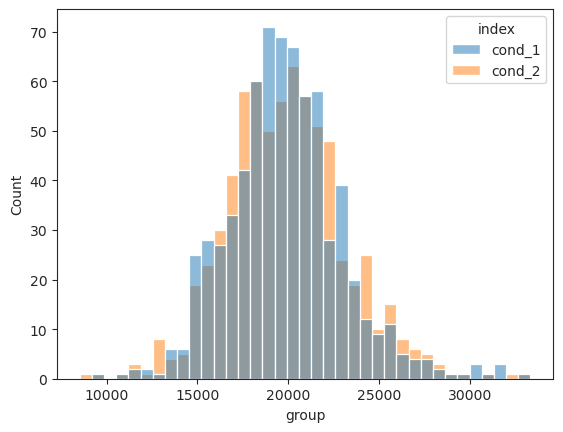

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(pd.concat(n_cells_difs).reset_index(), x='group', hue='index')

<Axes: xlabel='group', ylabel='Count'>

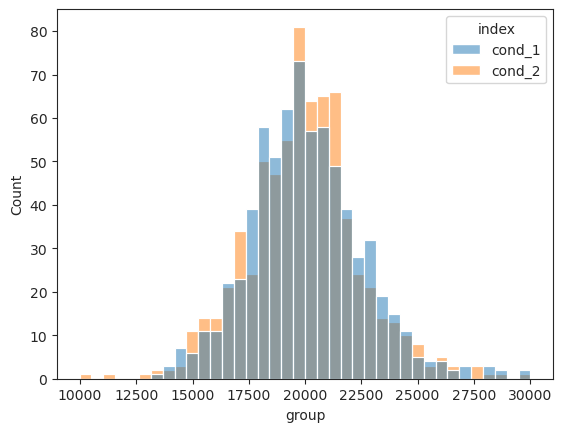

In [18]:
sns.histplot(pd.concat(n_cells_null).reset_index(), x='group', hue='index')